<a href="https://colab.research.google.com/github/Pietrosittoni/NoVax_Speech_on_Twitter/blob/main/Prevax_Filtering_and_working_on_italian_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install python-igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.2 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9076 sha256=c23310cc30c58bae05df7e496dac127033608613cc991ea0bdcd9430c7ccb902
  Stored in directory: /root/.cache/pip/wheels/04/eb/68/b70fc5f1163b5a3e9e6aaaea5fb57a8ff4c0c4988505a4fe0f
Successfully built python-igraph


In [ ]:
!pip install --upgrade scipy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 32.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import requests 
import pandas as pd 
import time
import itertools
import igraph as ig
import networkx as nx
import networkx.algorithms.community as nx_comm

In [ ]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=f403f82fb20135d0170d6f1b9b4111ec70b0323c0f1a1a60880dd9560fc17503
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


If you want to load the results you have previously saved, simply execute the next code, specifying the path to the file.

You will need to either upload it to the Colab workspace or copy the path to the file on Drive.

# *Load data*


In [ ]:
path = "/content/drive/MyDrive/Network_Science_covid_project/Nuovi_tweets/df_tweets_prevax.pkl"
tweets_df = pd.read_pickle(path)
path = "/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp"

# *Filtering Twitter data*

## Step 1: Preprocessing the data

In [ ]:
tweets_df = tweets_df[tweets_df['lang']=="it"]

In [ ]:
tweets_df.shape

(11581, 14)

In [ ]:
tweets_filtered = tweets_df.copy() 
column_list = ["id","author_id","created_at", "text","entities","public_metrics", "lang"]
unique_hashtags_prevax = tweets_filtered[column_list]

In [ ]:
tweets_df.index = [i for i in range(tweets_df.shape[0])]

## Step 2: Extracting hashtags

In [ ]:
tweets_filtered.loc[tweets_filtered["entities"].isnull(), "entities"] = None

In [ ]:
tweets_filtered["hashtags"] = ""

In [ ]:
unique_hashtags = {}
index = 0
for idx, row in tweets_filtered.iterrows():
  if row["entities"] is not None and "hashtags" in row["entities"]:
    hl = []
    for hashtag in row["entities"]["hashtags"]:
      tag = "#"+hashtag["tag"]
      if  tag not in ["#nogreenpassobbligatorio","#NoVaccinoObbligatorio","#DittaturaSanitaria", "#novaccinoCOVID","#nocavie","#primule","#ProVaccino"]:    
        if tag=="#nogreenpassobbligatorio":
          print("problem")
        tag = tag.lower()
        unique_hashtags.setdefault(tag, 0)
        unique_hashtags[tag] += 1
        hl.append(tag)
        tweets_filtered.at[idx,"hashtags"] = [hl]

In [ ]:
i = 0
for idx, row in tweets_filtered.iterrows():
  if len(row["hashtags"])==1 and (type(row["hashtags"][0]) is list):
    tweets_filtered.loc[idx,"hashtags"] = row["hashtags"][0]
    if i==1:
      print("problem")
i = 1

In [ ]:
unique_hashtags = dict(sorted(unique_hashtags.items(), key=lambda item: item[1], reverse=True))

In [ ]:
uh_df = pd.DataFrame.from_dict(unique_hashtags, orient='index').reset_index()
uh_df.rename(columns = {'index':'Hashtag', 0:'Count'}, inplace=True)
uh_df.to_csv("/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/freq_hashtag_prevaxcamp.csv")

In [ ]:
uh_df[0:5]

,Hashtag,Count
0,#negazionisti,1141
1,#dittaturasanitaria,1077
2,#covid19,768
3,#conte,684
4,#nomask,387


## Step3 : Extracting Words

In [ ]:
import re
import string
# NLTK tools
import nltk
nltk.download('words')
#words = set(nltk.corpus.words.words())
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("italian")
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from collections import defaultdict
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
stop_words.append('rt')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
pp=pd.read_csv('/content/drive/MyDrive/Network_Science_covid_project/60000_parole_italiane.txt',header=None)
words=[str(pp[0][i]) for i in range(len(pp))]

In [ ]:
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) # remove mentions
    tweet = re.sub("#[A-Za-z0-9]+", "",tweet) # remove hashtags
    tweet = re.sub("_[A-Za-z0-9]+", "",tweet)
    tweet = str.lower(tweet) #to lowercase
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links
    tweet = " ".join(tweet.split())
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) if w in words and not w in stop_words)
     #remove stop words
    lemma_function = WordNetLemmatizer()
    tweet = " ".join(lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in nltk.pos_tag(nltk.wordpunct_tokenize(tweet))) #lemmatize
    tweet = [i for i in tweet.split(' ') if len(i)>2]
    tweet = " ".join(tweet)
    return tweet

In [ ]:
tweets_filtered["clean_text"] = tweets_filtered["text"].map(cleaner)

In [ ]:
tweets_filtered

,public_metrics,created_at,referenced_tweets,text,conversation_id,author_id,id,lang,entities,reply_settings,edit_history_tweet_ids,in_reply_to_user_id,context_annotations,geo,hashtags,clean_text
0,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",2020-04-01T20:45:20.000Z,"[{'type': 'retweeted', 'id': '1245444617002201...",RT @domalex82: Volere #Draghi per liberarsi di...,1245452208763781123,1175679259,1245452208763781123,it,"{'mentions': [{'start': 3, 'end': 13, 'usernam...",everyone,[1245452208763781123],NaN,NaN,NaN,"[#bielorussa, #lukashenko]",volere chiedere aiuto vampiro cacciare conte poi
1,"{'retweet_count': 1, 'reply_count': 3, 'like_c...",2020-04-01T20:15:10.000Z,NaN,Volere #Draghi per liberarsi di #Conte è come ...,1245444617002201094,319106670,1245444617002201094,it,"{'hashtags': [{'start': 7, 'end': 14, 'tag': '...",everyone,[1245444617002201094],NaN,NaN,NaN,"[#bielorussa, #lukashenko]",volere chiedere aiuto vampiro cacciare conte p...
2,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2020-04-01T11:26:39.000Z,"[{'type': 'replied_to', 'id': '124526422268832...",@cristin40483739 @TgLa7 @robersperanza Ormai #...,1245259727082336256,2322670973,1245311610769543168,it,"{'mentions': [{'start': 0, 'end': 16, 'usernam...",everyone,[1245311610769543168],862048421439524869,NaN,NaN,"[#bielorussa, #lukashenko]",ormai pensiamo solo sani curare malati
0,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",2020-04-02T19:46:51.000Z,NaN,"E no cari, dovete pagare fino all'ultimo morto...",1245799879378690049,319106670,1245799879378690049,it,"{'urls': [{'start': 163, 'end': 186, 'url': 'h...",everyone,[1245799879378690049],NaN,"[{'domain': {'id': '123', 'name': 'Ongoing New...",NaN,"[#bielorussa, #lukashenko]",cari dovete pagare fino ultimo morto oggi
1,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",2020-04-02T17:42:24.000Z,NaN,E' per questo che l'Italia ha il record di mor...,1245768559378210816,319106670,1245768559378210816,it,"{'urls': [{'start': 277, 'end': 300, 'url': 'h...",everyone,[1245768559378210816],NaN,"[{'domain': {'id': '123', 'name': 'Ongoing New...",NaN,"[#bielorussa, #lukashenko]",record morti mentre numero decessi ridicolo em...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,"{'retweet_count': 4, 'reply_count': 3, 'like_c...",2020-09-29T06:33:26.000Z,NaN,Mi chiedo : ma i tamponi hanno una memoria int...,1310830022673006597,2153639454,1310830022673006597,it,"{'hashtags': [{'start': 99, 'end': 107, 'tag':...",everyone,[1310830022673006597],NaN,"[{'domain': {'id': '123', 'name': 'Ongoing New...",NaN,"[#covid19, #dittaturasanitaria]",chiedo tamponi memoria distinguere semplice ch...
26,"{'retweet_count': 7, 'reply_count': 0, 'like_c...",2020-09-29T06:26:59.000Z,"[{'type': 'retweeted', 'id': '1310823296506753...",RT @grande_luciano: 14 calciatori del #Genoa p...,1310828400626597889,2385068164,1310828400626597889,it,"{'hashtags': [{'start': 38, 'end': 44, 'tag': ...",everyone,[1310828400626597889],NaN,NaN,NaN,[#genoa],positivi intanto giocato partita vuol dire tam...
27,"{'retweet_count': 7, 'reply_count': 0, 'like_c...",2020-09-29T06:10:44.000Z,"[{'type': 'retweeted', 'id': '1310823296506753...",RT @grande_luciano: 14 calciatori del #Genoa p...,1310824311943565312,830834103033458689,1310824311943565312,it,"{'hashtags': [{'start': 38, 'end': 44, 'tag': ...",everyone,[1310824311943565312],NaN,NaN,NaN,[#genoa],positivi intanto giocato partita vuol dire tam...
28,"{'retweet_count': 7, 'reply_count': 1, 'like_c...",2020-09-29T06:06:42.000Z,NaN,"14 calciatori del #Genoa positivi,intanto hann...",1310823296506753026,2153639454,1310823296506753026,it,"{'hashtags': [{'start': 18, 'end': 24, 'tag': ...",everyone,[1310823296506753026],NaN,NaN,NaN,"[#genoa, #dittaturasanitaria]",positivi intanto giocato partita vuol dire tam...


In [ ]:
tweets_filtered.loc[tweets_filtered["clean_text"].isnull(),"clean_text"] = ""

In [ ]:
tweet_tokenizer = nltk.TweetTokenizer()

#initialize an empty dict
unique_words = {}

for idx, row in tweets_filtered.iterrows():
  if row["clean_text"] != "":
    for word in tweet_tokenizer.tokenize(row["clean_text"]):
      unique_words.setdefault(word,0)
      unique_words[word] += 1

In [ ]:
uw_df = pd.DataFrame.from_dict(unique_words, orient='index').reset_index()
uw_df.rename(columns = {'index':'Word', 0:'Count'}, inplace=True)
uw_df.sort_values(by=['Count'], ascending=False, inplace=True)
uw_df = uw_df.reset_index().drop(columns=["index"])
uw_df.to_csv("/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/freq_words_prevaxcamp.csv")

In [ ]:
uw_df.head(30)

,Word,Count
0,morti,935
1,basta,744
2,terapia,671
3,pagare,666
4,tasse,646
5,obbliga,621
6,letto,613
7,garantire,610
8,ieri,554
9,stato,539


## Step 4: Building the network hashtags

In [ ]:
uh = unique_hashtags_prevax.keys()

In [ ]:
# network hashtag
network_hashtag = {}
network_key_hashtag = 0
for index, row in tweets_filtered.iterrows():
    combined_list = [hashtag for hashtag in row["hashtags"]] 
    #itertool product creates Cartesian product of each element in the combined list
    for pair in itertools.product(combined_list, combined_list):
        #exclude self-loops and count each pair only once because our graph is undirected and we do not take self-loops into account
        if pair[0]!=pair[1] and not(pair[::-1] in network_hashtag):
            network_hashtag.setdefault(pair,0)
            network_hashtag[pair] += 1 
network_df_hashtag = pd.DataFrame.from_dict(network_hashtag, orient="index")

In [ ]:
#####################
##hashtag
network_df_hashtag.reset_index(inplace=True)
network_df_hashtag.columns = ["pair","weight"]
network_df_hashtag.sort_values(by="weight",inplace=True, ascending=False)

In [ ]:
#hashtag
#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted_hashtag_prevax = []
for edge in network_hashtag:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_hashtag_prevax.append((edge[0],edge[1],network_hashtag[edge]))

G_hashtag = nx.Graph()
G_hashtag.add_weighted_edges_from(up_weighted_hashtag_prevax)

In [ ]:
print(len(G_hashtag.nodes()))
print(len(G_hashtag.edges()))

354
1675


## save edges

In [ ]:
filename_prevax = "/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_hashtag_prevaxcamp.csv"

In [ ]:
nx.write_weighted_edgelist(G_hashtag, filename_prevax, delimiter=",")

## Building the words hashtgs

In [ ]:
uh = unique_hashtags_prevax.keys()
#uw = unique_words.keys()  

In [ ]:
network = {}
network_key = 0
for index, row in tweets_filtered.iterrows():
    combined_list = [hashtag for hashtag in row["hashtags"]] + [word for word in str.split(row["clean_text"], " ") if word in uw]
    #itertool product creates Cartesian product of each element in the combined list
    for pair in itertools.product(combined_list, combined_list):
        #exclude self-loops and count each pair only once because our graph is undirected and we do not take self-loops into account
        if pair[0]!=pair[1] and not(pair[::-1] in network):
            network.setdefault(pair,0)
            network[pair] += 1 
    
network_df = pd.DataFrame.from_dict(network, orient="index")

KeyError: ignored

In [ ]:
network_df.reset_index(inplace=True)
network_df.columns = ["pair","weight"]
network_df.sort_values(by="weight",inplace=True, ascending=False)
network_df

,pair,weight
0,"(#bielorussa, #lukashenko)",2040
56209,"(morti, neanche)",698
138,"(morti, viene)",697
56208,"(morti, sappia)",696
56210,"(morti, corretto)",696
...,...,...
45813,"(qualora, dovessero)",1
45812,"(autorizzato, remota)",1
45811,"(autorizzato, affatto)",1
45810,"(autorizzato, ipotesi)",1


In [ ]:
#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted = []
for edge in network:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted.append((edge[0],edge[1],network[edge]))

G_hybrid = nx.Graph()
G_hybrid.add_weighted_edges_from(up_weighted)

In [ ]:
print(len(G_hybrid.nodes()))
print(len(G_hybrid.edges()))

5392
114207


#### Save edgelist

In [ ]:
filename_prevax = "/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_words_prevaxcamp.csv"

In [ ]:
nx.write_weighted_edgelist(G_hybrid, filename_prevax, delimiter=",")

# *Working on Network, hashtag* 

In this part we will start analyzing the netwrok propiety


## We really need all the nodes? Probably not but let's see 

#### Instead to re run evrything we import the edgelist


In [ ]:
up_weighted_hashtag_prevax = []
edge_prevax = pd.read_csv('/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_hashtag_prevaxcamp.csv',header=None)
for i in range(edge_prevax.shape[0]):
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_hashtag_prevax.append((edge_prevax.iloc[i,0],edge_prevax.iloc[i,1],edge_prevax.iloc[i,2]))

G_hashtag = nx.Graph()
G_hashtag.add_weighted_edges_from(up_weighted_hashtag_prevax)

### Frquencies of the hashtag

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


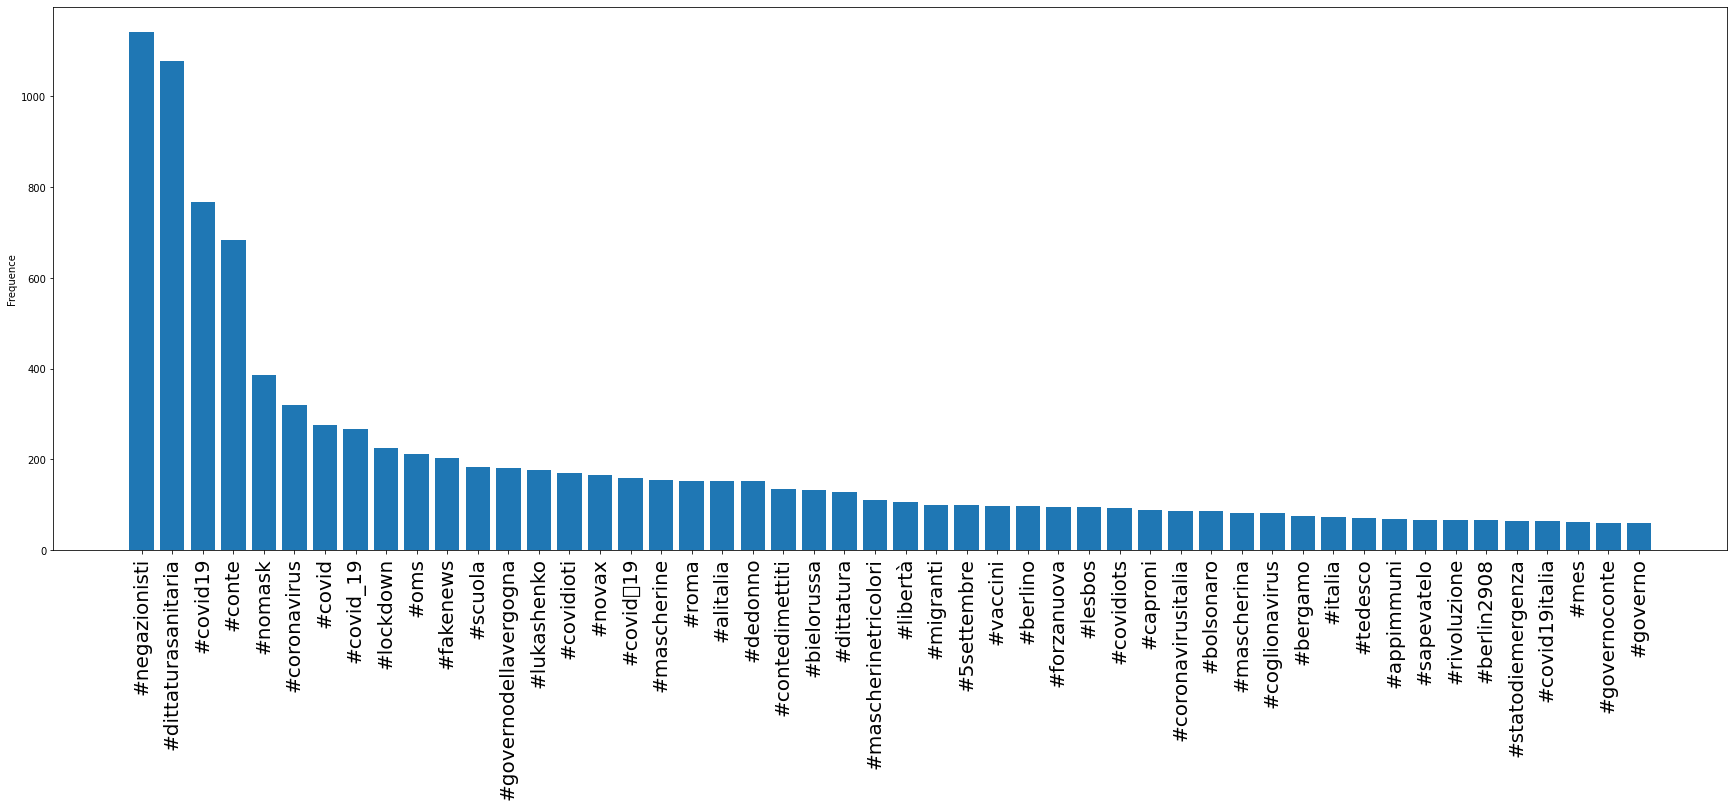

In [ ]:
hashtags = pd.read_csv("/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/freq_hashtag_prevaxcamp.csv")
plt.figure(figsize=(30,10))
plt.bar(hashtags[0:50]["Hashtag"],height=hashtags[0:50]["Count"])
plt.xticks(rotation=90,fontsize=20)
plt.ylabel("Frequence")
#plt.xlabel("Nodes")
#plt.savefig('test.pdf')
plt.show()

### Pagerank 

Ascending and descending

In [ ]:
## Try different teletrasportation :)
print("\t \t \t \t \t \t \t \t \t Pagerank with different alpha")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
pr70 = nx.pagerank(G_hashtag,alpha=0.70)
pr_sort70 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr75 = nx.pagerank(G_hashtag,alpha=0.75)
pr_sort75 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr80 = nx.pagerank(G_hashtag,alpha=0.80)
pr_sort80 = {k : v for k, v in sorted(pr80.items(), key = lambda t : t[1], reverse = True)}

pr85= nx.pagerank(G_hashtag,alpha=0.85,max_iter=100000)
pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = True)}


fig, ax = plt.subplots(2, 2,figsize=(70,50))

ax[0,0].bar(list(pr_sort85.keys())[0:50],height=list(pr_sort85.values())[0:50])
ax[0,0].tick_params(axis='x',labelrotation=90)
ax[0,0].set_ylabel('Pagerank',fontsize = 20)
ax[0,0].set_xlabel('Nodes',fontsize = 20)
ax[0,0].set_title("Alpha = 0.85",fontsize = 20)

ax[0,1].bar(list(pr_sort80.keys())[0:50],height=list(pr_sort80.values())[0:50])
ax[0,1].tick_params(axis='x',labelrotation=90)
ax[0,1].set_ylabel('Pagerank',fontsize = 20)
ax[0,1].set_xlabel('Nodes',fontsize = 20)
ax[0,1].set_title("Alpha = 0.80",fontsize = 20)

ax[1,0].bar(list(pr_sort75.keys())[0:50],height=list(pr_sort75.values())[0:50])
ax[1,0].tick_params(axis='x',labelrotation=90)
ax[1,0].set_ylabel('Pagerank',fontsize = 20)
ax[1,0].set_xlabel('Nodes',fontsize = 20)
ax[1,0].set_title("Alpha = 0.75",fontsize = 20)

ax[1,1].bar(list(pr_sort70.keys())[0:50],height=list(pr_sort70.values())[0:50])
ax[1,1].tick_params(axis='x',labelrotation=90)
ax[1,1].set_ylabel('Pagerank',fontsize = 20)
ax[1,1].set_xlabel('Nodes',fontsize = 20)
ax[1,1].set_title("Alpha = 0.70",fontsize = 20)
plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


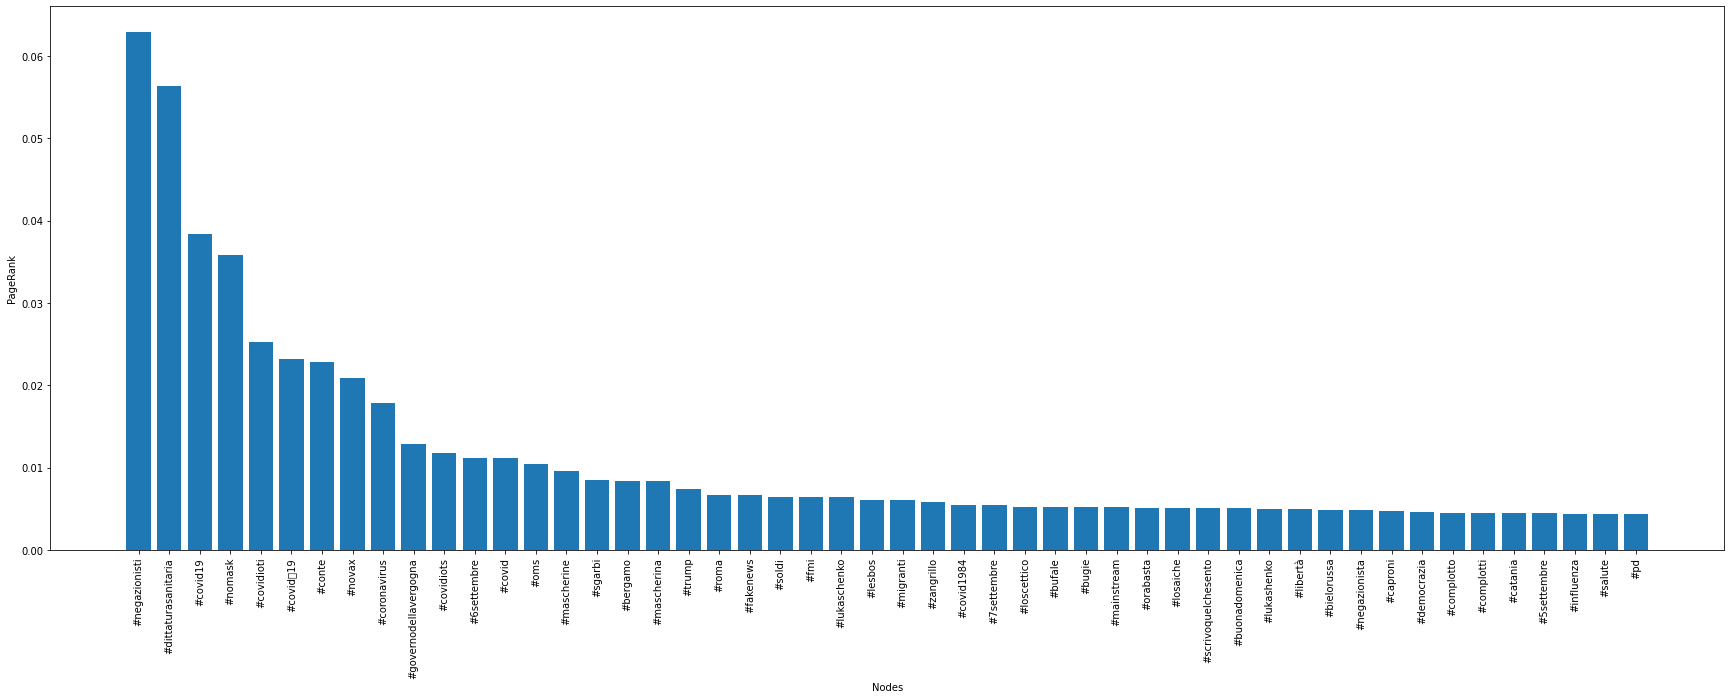

In [ ]:
pr85= nx.pagerank(G_hashtag,alpha=0.85)

pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = True)}

plt.figure(figsize=(30,10))
plt.bar(list(pr_sort85.keys())[0:50],height=list(pr_sort85.values())[0:50])
plt.xticks(rotation=90)
plt.ylabel("PageRank")
plt.xlabel("Nodes")

plt.show()

In [ ]:
## Try different teletrasportation :)
print("\t \t \t \t \t \t \t \t \t Pagerank with different alpha")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
pr70 = nx.pagerank(G_hashtag,alpha=0.70)
pr_sort70 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = False)}

pr75 = nx.pagerank(G_hashtag,alpha=0.75)
pr_sort75 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = False)}

pr80 = nx.pagerank(G_hashtag,alpha=0.80)
pr_sort80 = {k : v for k, v in sorted(pr80.items(), key = lambda t : t[1], reverse = False)}

pr85= nx.pagerank(G_hashtag,alpha=0.85,max_iter=100000)
pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = False)}


fig, ax = plt.subplots(2, 2,figsize=(70,50))

ax[0,0].bar(list(pr_sort85.keys())[0:50],height=list(pr_sort85.values())[0:50])
ax[0,0].tick_params(axis='x',labelrotation=90)
ax[0,0].set_ylabel('Pagerank',fontsize = 20)
ax[0,0].set_xlabel('Nodes',fontsize = 20)
ax[0,0].set_title("Alpha = 0.85",fontsize = 20)

ax[0,1].bar(list(pr_sort80.keys())[0:50],height=list(pr_sort80.values())[0:50])
ax[0,1].tick_params(axis='x',labelrotation=90)
ax[0,1].set_ylabel('Pagerank',fontsize = 20)
ax[0,1].set_xlabel('Nodes',fontsize = 20)
ax[0,1].set_title("Alpha = 0.80",fontsize = 20)

ax[1,0].bar(list(pr_sort75.keys())[0:50],height=list(pr_sort75.values())[0:50])
ax[1,0].tick_params(axis='x',labelrotation=90)
ax[1,0].set_ylabel('Pagerank',fontsize = 20)
ax[1,0].set_xlabel('Nodes',fontsize = 20)
ax[1,0].set_title("Alpha = 0.75",fontsize = 20)

ax[1,1].bar(list(pr_sort70.keys())[0:50],height=list(pr_sort70.values())[0:50])
ax[1,1].tick_params(axis='x',labelrotation=90)
ax[1,1].set_ylabel('Pagerank',fontsize = 20)
ax[1,1].set_xlabel('Nodes',fontsize = 20)
ax[1,1].set_title("Alpha = 0.70",fontsize = 20)
plt.show()


### Node degree

Ascending and descending

In [ ]:
most_imp

#negazionisti                     162
#dittaturasanitaria                91
#covidー19                          89
#nomask                            83
#covid19                           80
                                 ... 
#oppressionedeipusher               1
#valhalla                           1
#opatriaomuerte                     1
#coreadelnord                       1
#qualcunovolòsulnidodelcucuclo      1
Length: 354, dtype: int64

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


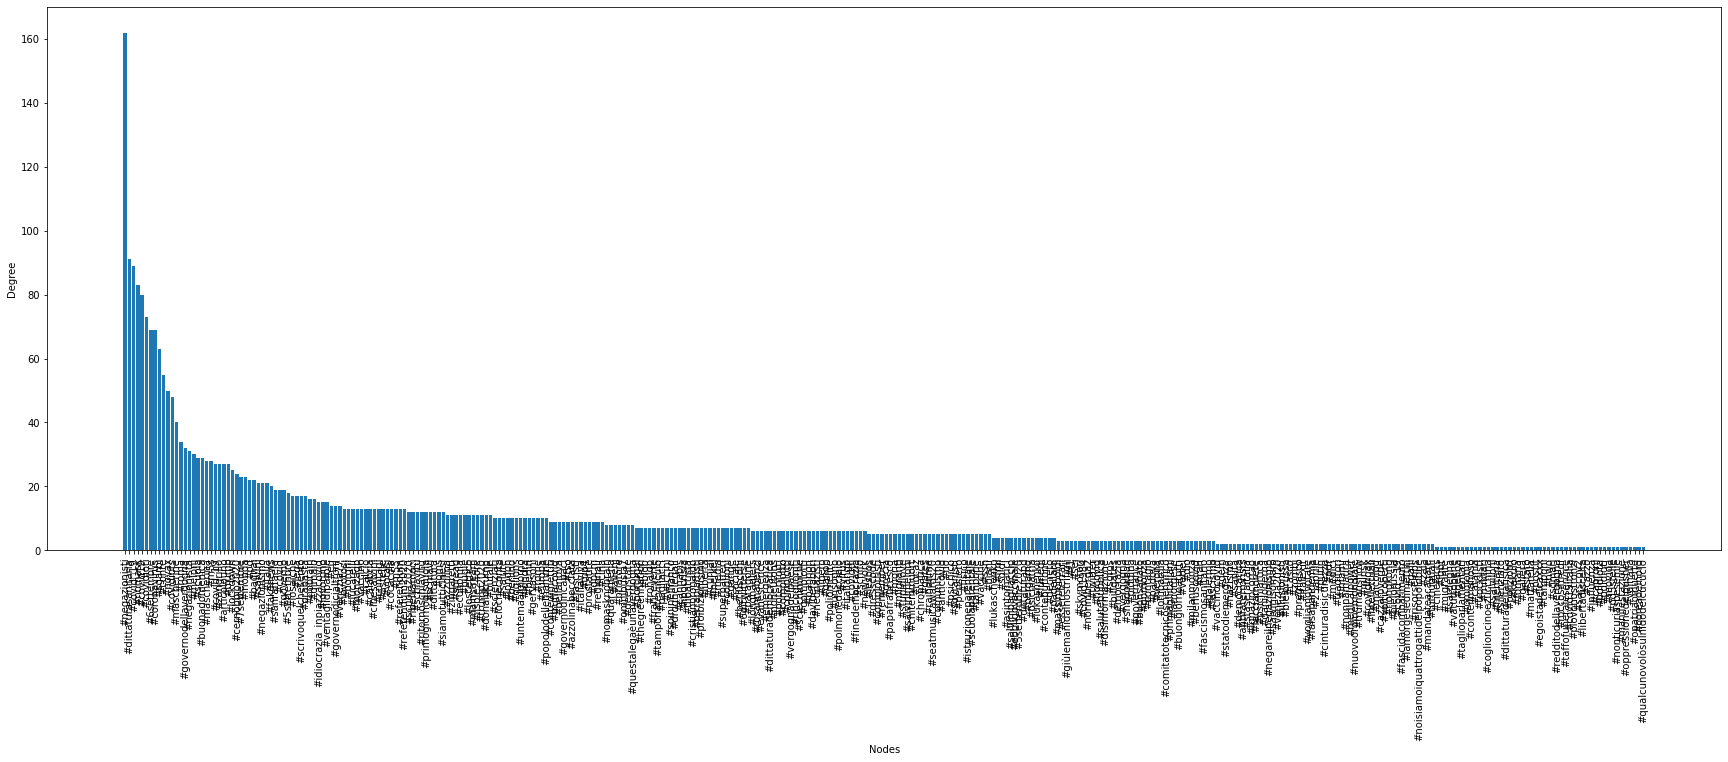

In [ ]:
most_imp = pd.Series(dict(G_hashtag.degree)).sort_values(ascending=False)
plt.figure(figsize=(30,10))
plt.bar(most_imp.index,height=most_imp)
plt.xticks(rotation=90)

plt.ylabel("Degree",fontsize=10)
plt.xlabel("Nodes",fontsize=10)
plt.show()

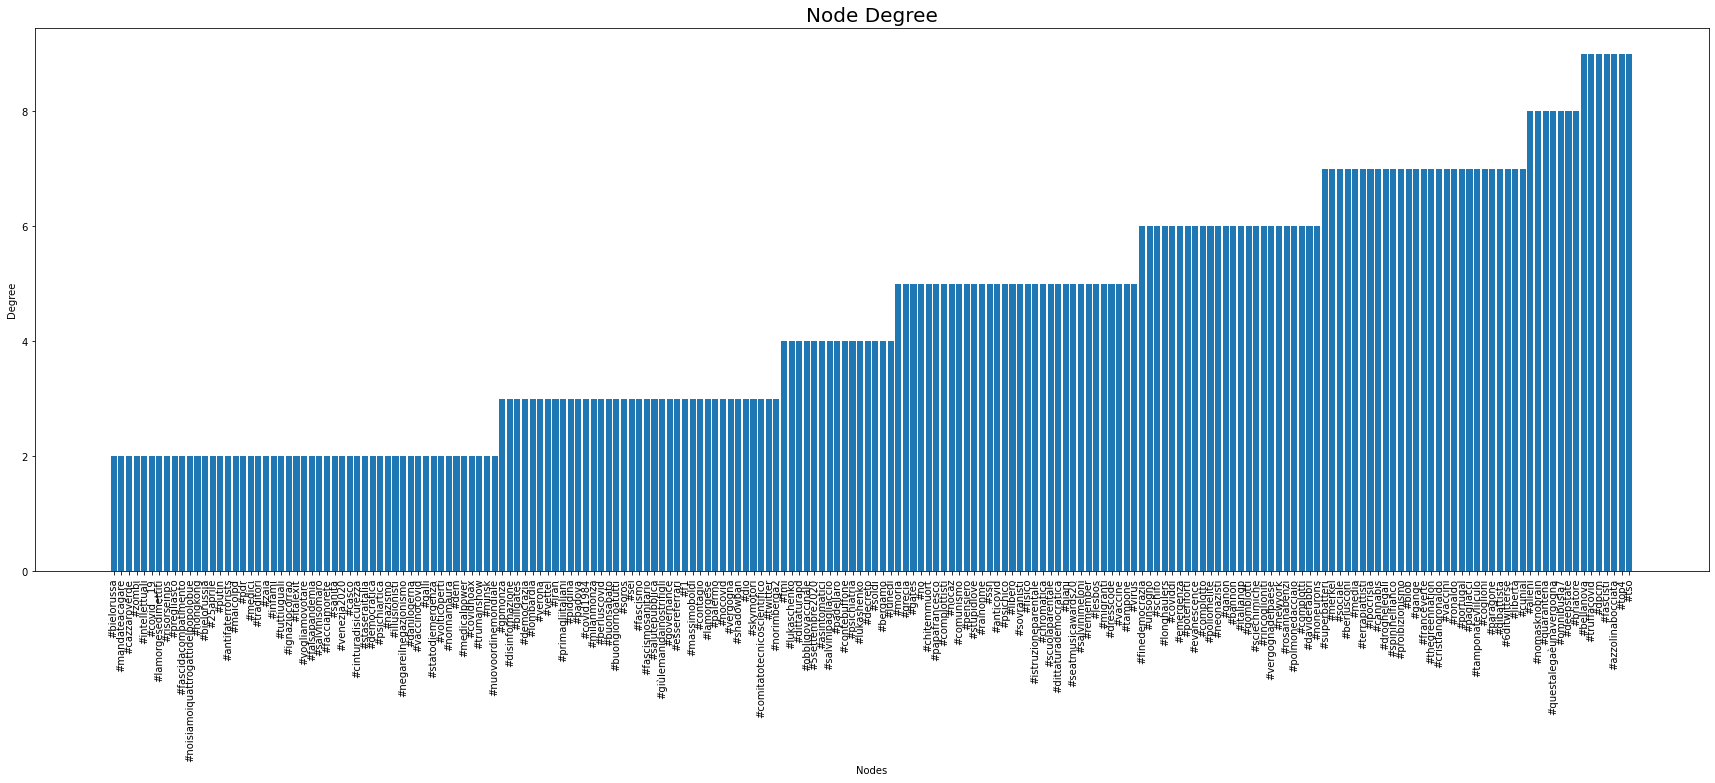

In [ ]:
less_imp = pd.Series(dict(G_hashtag.degree)).sort_values(ascending=True)[:200]
plt.figure(figsize=(30,10))
plt.bar(less_imp.index,height=less_imp)
plt.xticks(rotation=90)
plt.title("Node Degree",fontsize=20)
plt.ylabel("Degree",fontsize=10)
plt.xlabel("Nodes",fontsize=10)
plt.show()

In [ ]:
blacklist = list(most_imp[(most_imp>5000)].index)
blacklist.extend(list(less_imp[(less_imp<2)].index))
blacklist

[]

## As we can notice the first 2 node have a really high frequqncy, node degree & Pagerank

So we will discard them because think about the com. detect. Also the node with a small degree and 

In [ ]:
up_weighted_hashtag_prevax = []
edge_prevax = pd.read_csv('/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_hashtag_prevaxcamp.csv',header=None)
for i in range(edge_prevax.shape[0]):
  if (edge_prevax.iloc[i,0] not in blacklist) and(edge_prevax.iloc[i,1] not in blacklist):
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_hashtag_prevax.append((edge_prevax.iloc[i,0],edge_prevax.iloc[i,1],edge_prevax.iloc[i,2]))

G_hashtag = nx.Graph()
G_hashtag.add_weighted_edges_from(up_weighted_hashtag_prevax)

NameError: ignored

In [ ]:
filename_prevax = "/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_hashtag_prevaxcamp.csv"
nx.write_weighted_edgelist(G_hashtag, filename_prevax, delimiter=",")

### The network is connected? (If not wich are tha connected componets)

In [ ]:
iG_hashtag = ig.Graph.from_networkx(G_hashtag)
print("\t \t \t \t \t \t  \t \t \t  CONNECTION")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Is the graph connected:","YES" if iG_hashtag.is_connected() else "NO")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("The connected componet are:")
print("\t")
#IF NOT YOU CAN FIND ISOLATED COMPONENENTS
skip = True 
isolated = {}
i = 1
for component in iG_hashtag.components():
  print(component)
  if not skip:
    isolated[i] = component
    i+=1
  skip =False
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  


	 	 	 	 	 	  	 	 	  CONNECTION
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pandas.core.common import flatten
isolated_list = list(flatten(list(isolated.values())))
isolated_list
temp = [len(i) for i in isolated.values()]
find_the_comunities = dict(zip([i+1 for i in range(len(isolated.keys()))],temp))

In [ ]:
counter = 0
find_counter = 1
check_com = 0
isolated = []
print("\t \t \t  Hashtag of the connected component")
print("--------------------------------------------------------------------------------------------")
for vertice in iG_hashtag.vs:
    if counter in isolated_list:
      if check_com==find_the_comunities[find_counter]:
        print("--------------------------------------------------------------------------------------------")
        find_counter+=1
        check_com=0
      isolated.append(vertice.attributes()['_nx_name'])
      print(f" The hashtag {vertice.attributes()['_nx_name'].upper()}, is in the isolated component number: {find_counter}")
      check_com+=1
    counter+=1
print("--------------------------------------------------------------------------------------------")

	 	 	  Hashtag of the connected component
--------------------------------------------------------------------------------------------
 The hashtag #FALSAPANDEMIA, is in the isolated component number: 1
 The hashtag #VOGLIAMOVOTARE, is in the isolated component number: 1
 The hashtag #ITALEXIT, is in the isolated component number: 1
--------------------------------------------------------------------------------------------


In [ ]:
up_weighted_hashtag_connected = []
edge = pd.read_csv("/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_hashtag_prevaxcamp.csv",header=None)
index_comp_con = []
for i in range(edge.shape[0]):
      if (edge.iloc[i,0] not in isolated) and (edge.iloc[i,1] not in isolated) and (edge.iloc[i,2]>0) and not (edge.iloc[i,1] in blacklist) and not (edge.iloc[i,0] in blacklist):
        #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
        #if(network[edge])>1: 
        up_weighted_hashtag_connected.append((edge.iloc[i,0],edge.iloc[i,1],edge.iloc[i,2]))
        index_comp_con.append(i)
      
G_hashtag_connected= nx.Graph()
G_hashtag_connected.add_weighted_edges_from(up_weighted_hashtag_connected)

NameError: ignored

In [ ]:
edge.iloc[index_comp_con,:].to_csv("/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_hashtag_clean_prevaxcamp.csv",header=None)

In [ ]:
edge.iloc[index_comp_con,:]

,0,1,2
0,#bielorussa,#lukashenko,2040
1,#bielorussa,#covidhoax,7
2,#lukashenko,#covidhoax,7
3,#lukashenko,#minsk,2
4,#lukashenko,#dittaturasanitaria,1
...,...,...,...
1630,#shadowban,#dittaturapd,1
1631,#antifaterrorists,#dem,3
1632,#skymotori,#f1,1
1633,#skymotori,#essereferrari,1


## Working on the giant Network component

#### Instead to re run evrything we import the edgelist


In [ ]:
up_weighted_hashtag_prevax = []
edge = pd.read_csv("/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_hashtag_clean_prevaxcamp.csv",header=None).iloc[:,1:]
for i in range(edge.shape[0]):
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_hashtag_prevax.append((edge.iloc[i,0],edge.iloc[i,1],edge.iloc[i,2]))

G_hashtag_connected = nx.Graph()
G_hashtag_connected.add_weighted_edges_from(up_weighted_hashtag_prevax)

In [ ]:
filename_prevax = "/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_hashtag_clean_connected.csv"
nx.write_weighted_edgelist(G_hashtag_connected, filename_prevax, delimiter=",")

In [ ]:
iG_hashtag_connected = ig.Graph.from_networkx(G_hashtag_connected)

#### Network diameter

In [ ]:
# DIAMETER - HOW FAR ARE THE TWO MOST DISTANT NODES

print("Network diameter:", iG_hashtag_connected.diameter(directed=False))

# GET NODES IN THE DIAMETER PATH 
diameter_path = []
d = iG_hashtag_connected.get_diameter()
for i in range(0, iG_hashtag_connected.diameter()):
  diameter_path.append((d[i], d[i+1]))
# GET EDGES IN THE DIAMETER PATH
diameter_edges = iG_hashtag_connected.get_eids(pairs=diameter_path, directed=False)


# AVERAGE PATH LENGTH - HOW CLOSE ARE THE NODES TO EACH OTHER ON AVERAGE

print("Average path length:", iG_hashtag_connected.average_path_length(directed=False))

Network diameter: 5
Average path length: 2.5318034806714924


In [ ]:
spl = dict(nx.all_pairs_shortest_path_length(G_hashtag_connected))

In [ ]:
rous = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}
u = []
for t in spl.keys():
  a = []
  for j in spl[t].values():
    if j not in a:
      l = len([k for k, v in spl[t].items() if v == j])
    rous[j]+= l
  a.append(j)

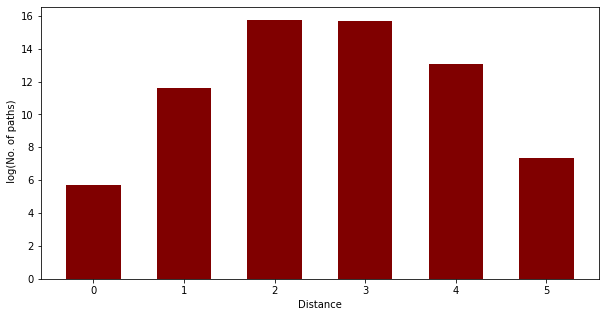

In [ ]:
data = rous
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, np.log(values), color ='maroon',
        width = 0.6)
 
plt.xlabel("Distance")
plt.ylabel(" log(No. of paths)")
plt.show()

### Node degree

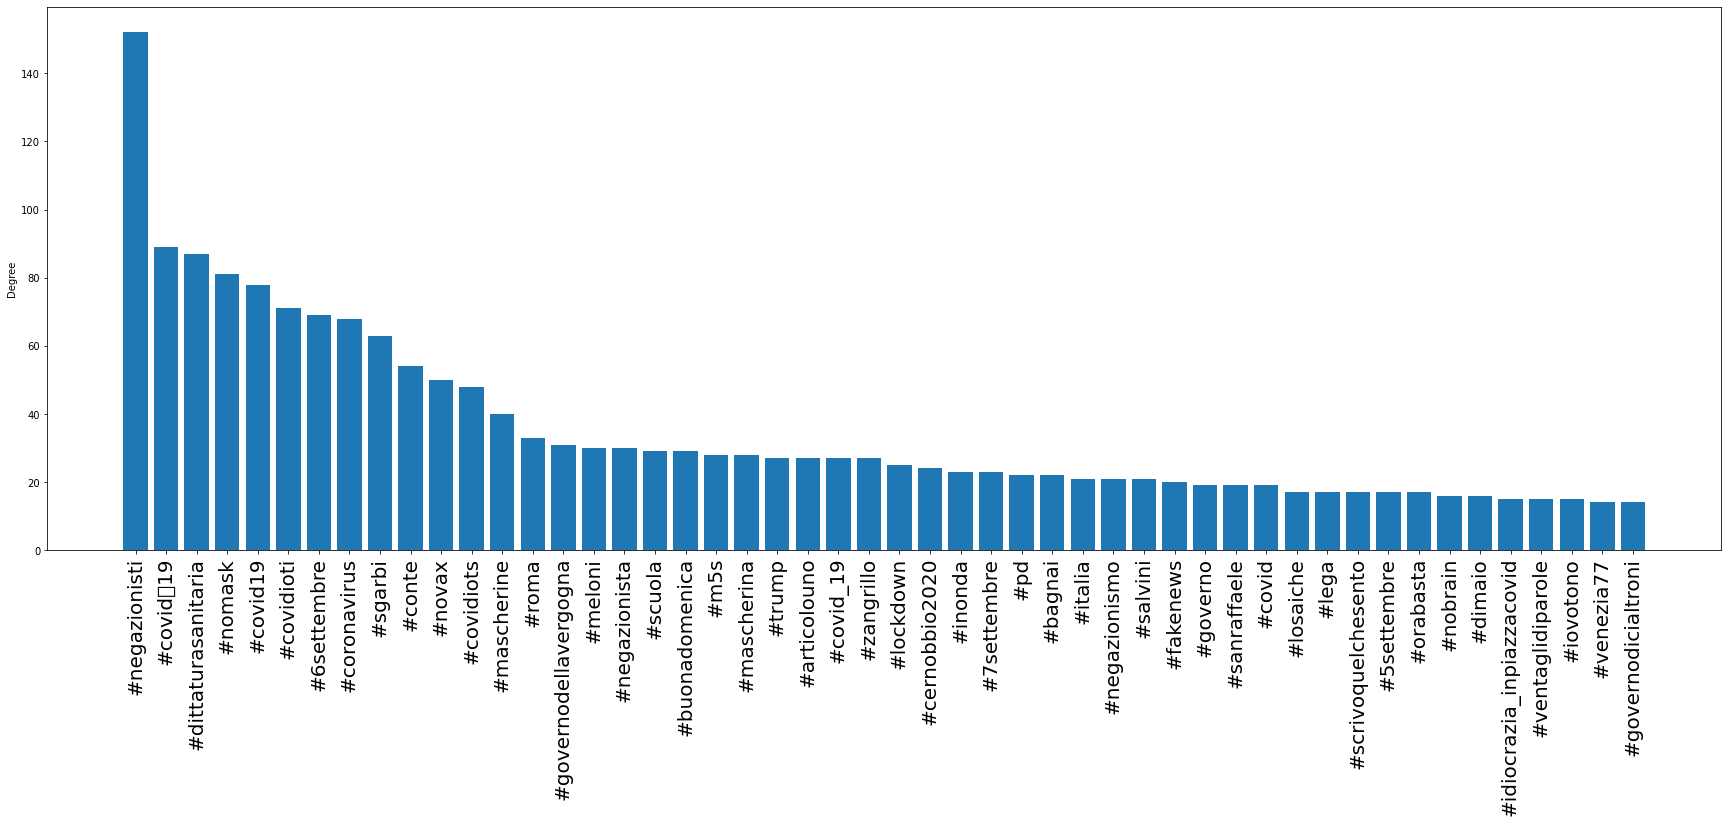

In [ ]:
most_imp = pd.Series(dict(G_hashtag_connected.degree)).sort_values(ascending=False)[:50]
plt.figure(figsize=(30,10))
plt.bar(most_imp.index,height=most_imp)
plt.xticks(rotation=90,fontsize=20)
#plt.title("Node Degree",fontsize=20)
plt.ylabel("Degree",fontsize=10)
#plt.xlabel("Nodes",fontsize=10)
plt.show()

In [ ]:
deg_dic = dict(G_hashtag_connected.degree) # keys: hashatgs, values: correspondent degree

In [ ]:
# rous is a dictionary where -> keys: degree, values: n° of times that degree appear

rous = {}
z = []
for j in deg_dic.values():
  if j not in z:
    l = len([k for k, v in deg_dic.items() if v == j])
    rous[j] = l
  z.append(j)

In [ ]:
sum(list(data.values()))

14119992

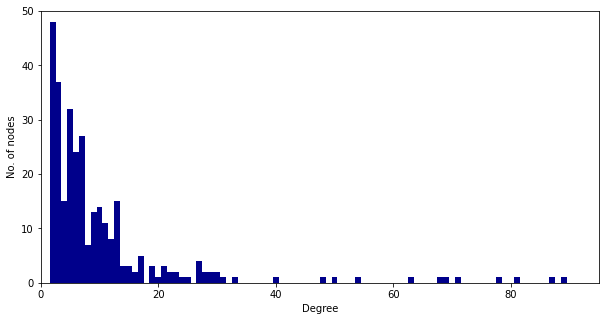

In [ ]:
data = rous
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='darkblue',
        width = 1)
plt.axis([0, 95, 0, 50])
plt.xlabel("Degree")
plt.ylabel("No. of nodes")

plt.show()

In [ ]:
pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-38-6b76528d4d1a>:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(pow_law2(G_hashtag_connected)))


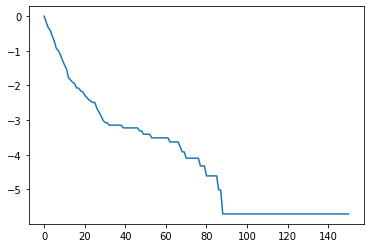

In [ ]:
plt.plot(np.log(pow_law2(G_hashtag_connected)))

In [ ]:
pow_law2(G_hashtag_connected)

Text(0, 0.5, 'log(CCDF)')

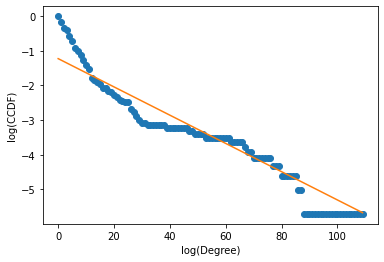

In [ ]:
def pow_law2(g):
  degrees = {}
  for node in g.nodes():
    key = len(list(g.neighbors(node)))
    degrees[key] = degrees.get(key, 0) + 1

  max_degree = max(degrees.keys(), key=int)
  num_nodes = []
  for i in range(1, max_degree + 1):
    num_nodes.append(degrees.get(i, 0))


  cum=[]
  t=0
  for x in num_nodes:
    t+=x
    cum.append(t)

  cum2=[]
  for x in cum:
    cum2.append(1-x/cum[-1])
  return cum2

plt.plot(np.log(pow_law2(G_hashtag_connected)[:110]),'o')
plt.plot(np.log([0.96**(x+30)  for x in range(len(pow_law2(G_hashtag_connected)[:110])) ]))
plt.xlabel("log(Degree)")
plt.ylabel("log(CCDF)")

In [ ]:
def av_degree(g):
  deg = dict(g.degree)
  av = sum(list(deg.values()))/len(list(deg.keys()))
  return av

# ------------------------------------------------------------

def nth_moment(g,n):
    s = 0
    for node in g.nodes:
        s += g.degree[node] ** n
    return (s/len(g))

# -----------------------------------------------------------

import powerlaw

def pow_law(g):
  degrees = {}
  for node in g.nodes():
    key = len(list(g.neighbors(node)))
    degrees[key] = degrees.get(key, 0) + 1

  max_degree = max(degrees.keys(), key=int)
  num_nodes = []
  for i in range(1, max_degree + 1):
    num_nodes.append(degrees.get(i, 0))

  fit = powerlaw.Fit(num_nodes)
  return fit.power_law.alpha+1

In [ ]:
print(r"The average degree of the Graph is:", av_degree(G_hashtag_connected))
print(r"The second moment Degree is:", nth_moment(G_hashtag_connected,2))
print(r"The third moment Degree is:", nth_moment(G_hashtag_connected,3))
print(r"Max Degree:", pd.Series(dict(G_hashtag_connected.degree)).sort_values(ascending=False)[0])
print(r"Min Degree:", pd.Series(dict(G_hashtag_connected.degree)).sort_values(ascending=False)[-1])

The average degree of the Graph is: 10.80794701986755
The second moment Degree is: 363.887417218543
The third moment Degree is: 27060.238410596026
Max Degree: 152
Min Degree: 2


### Degree distribution and Gamma estimation

In [ ]:
A = nx.adjacency_matrix(G_hashtag_connected)
d = np.sum(A,1)
d = np.squeeze(np.asarray(d))
d = d[d>0]
k = np.unique(d)
pk = np.histogram(d,k)[0]
pk = pk/np.sum(pk)
Pk = 1-np.cumsum(pk)

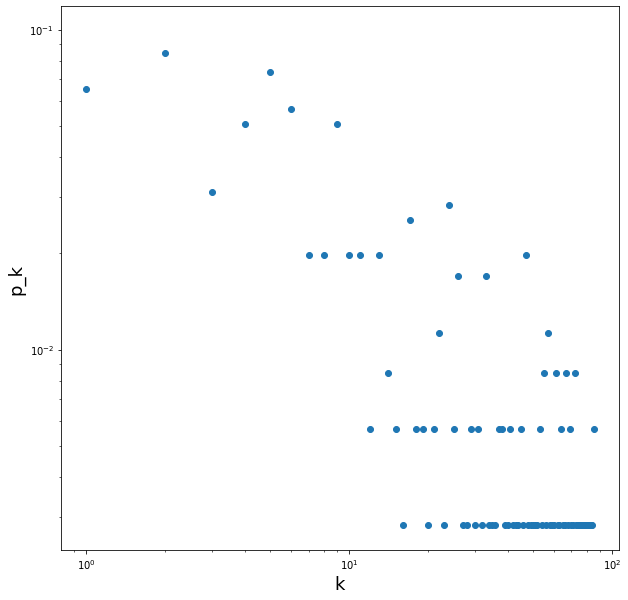

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.loglog(pk,'o')
plt.title("Degree Distribution",size=20)
plt.xlabel("k",size=18)
plt.ylabel("p_k",size=18)
plt.show()

In [ ]:
####### Gamma estimation
print("\t \t Gamma estimation (Free scale or random graph")
print("-------------------------------------------------------------------------")
d2 = d[d>=k.min()]
gamma = 1 + np.mean(np.log(d2/k.min()))
print(f"Gamma with the k min selected as the smallest neighbours, so k={k.min()}")
print(f"Gamma = {gamma}")
d2 = d[d>=5e1]
gamma = 1 + np.mean(np.log(d2/3e1))
print("-------------------------------------------------------------------------")
print(f"Gamma with the k min wisely selected, using the plot above, so k={3e1}")
print(f"Gamma = {gamma}")
print("-------------------------------------------------------------------------")

	 	 Gamma estimation (Free scale or random graph
-------------------------------------------------------------------------
Gamma with the k min selected as the smallest neighbours, so k=2
Gamma = 3.0573178768780656
-------------------------------------------------------------------------
Gamma with the k min wisely selected, using the plot above, so k=30.0
Gamma = 2.7787926461088928
-------------------------------------------------------------------------



### Pagerank 

	 	 	 	 	 	 	 	 	 Pagerank with different alpha
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


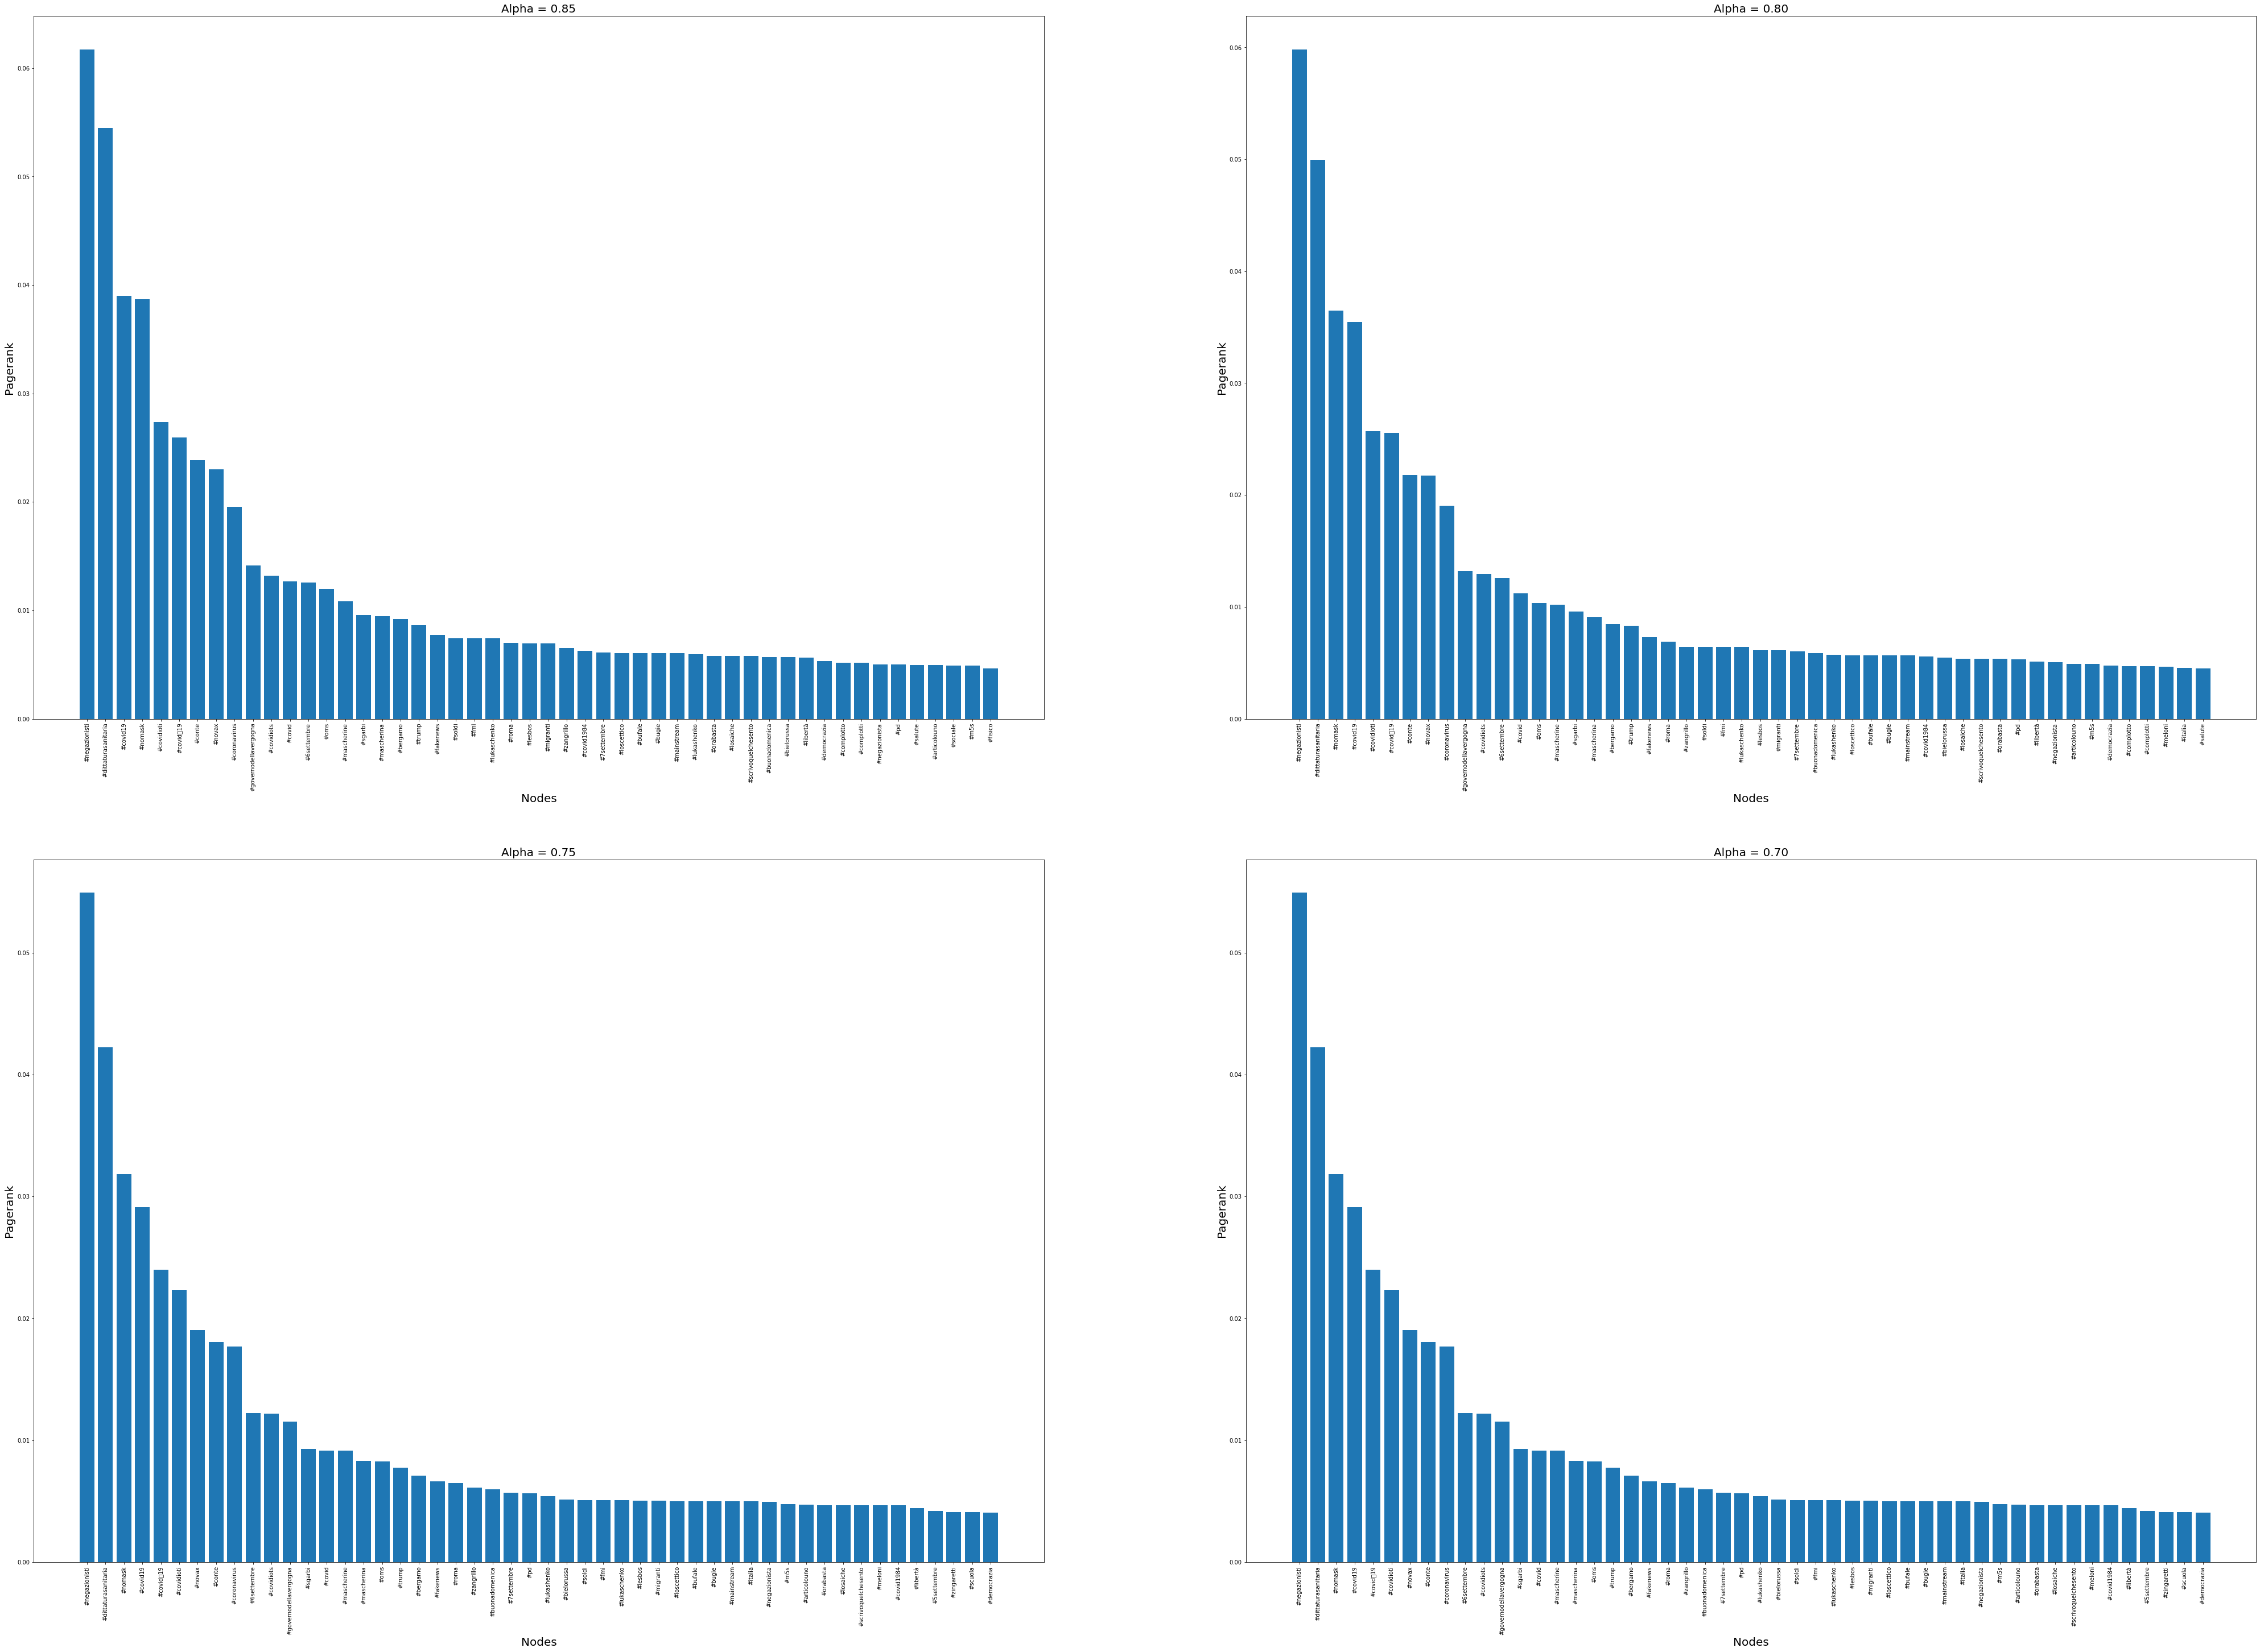

In [ ]:
## Try different teletrasportation :)
print("\t \t \t \t \t \t \t \t \t Pagerank with different alpha")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
pr70 = nx.pagerank(G_hashtag_connected,alpha=0.70)
pr_sort70 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr75 = nx.pagerank(G_hashtag_connected,alpha=0.75)
pr_sort75 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr80 = nx.pagerank(G_hashtag_connected,alpha=0.80)
pr_sort80 = {k : v for k, v in sorted(pr80.items(), key = lambda t : t[1], reverse = True)}

pr85= nx.pagerank(G_hashtag_connected,alpha=0.85,max_iter=100000)
pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = True)}


fig, ax = plt.subplots(2, 2,figsize=(70,50))

ax[0,0].bar(list(pr_sort85.keys())[0:50],height=list(pr_sort85.values())[0:50])
ax[0,0].tick_params(axis='x',labelrotation=90)
ax[0,0].set_ylabel('Pagerank',fontsize = 20)
ax[0,0].set_xlabel('Nodes',fontsize = 20)
ax[0,0].set_title("Alpha = 0.85",fontsize = 20)

ax[0,1].bar(list(pr_sort80.keys())[0:50],height=list(pr_sort80.values())[0:50])
ax[0,1].tick_params(axis='x',labelrotation=90)
ax[0,1].set_ylabel('Pagerank',fontsize = 20)
ax[0,1].set_xlabel('Nodes',fontsize = 20)
ax[0,1].set_title("Alpha = 0.80",fontsize = 20)

ax[1,0].bar(list(pr_sort75.keys())[0:50],height=list(pr_sort75.values())[0:50])
ax[1,0].tick_params(axis='x',labelrotation=90)
ax[1,0].set_ylabel('Pagerank',fontsize = 20)
ax[1,0].set_xlabel('Nodes',fontsize = 20)
ax[1,0].set_title("Alpha = 0.75",fontsize = 20)

ax[1,1].bar(list(pr_sort70.keys())[0:50],height=list(pr_sort70.values())[0:50])
ax[1,1].tick_params(axis='x',labelrotation=90)
ax[1,1].set_ylabel('Pagerank',fontsize = 20)
ax[1,1].set_xlabel('Nodes',fontsize = 20)
ax[1,1].set_title("Alpha = 0.70",fontsize = 20)
plt.show()


In [ ]:
pr85= nx.pagerank(G_hashtag_connected,alpha=0.85,max_iter=100000)
pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = True)}

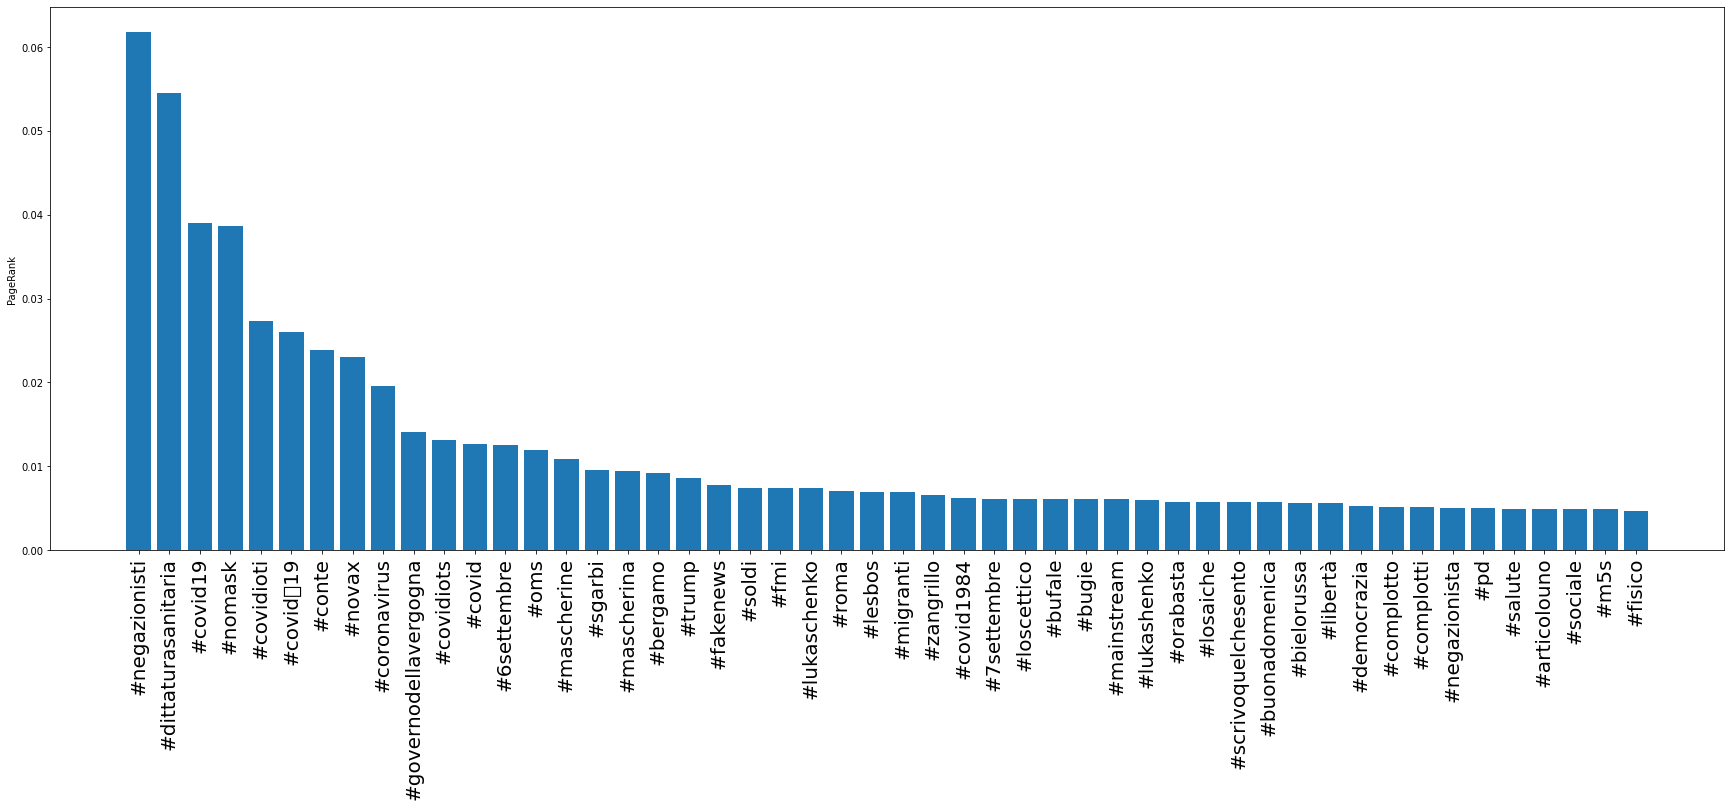

In [ ]:
pr85= nx.pagerank(G_hashtag_connected,alpha=0.85,max_iter=100000)
pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = True)}

plt.figure(figsize=(30,10))
plt.bar(list(pr_sort85.keys())[0:50],height=list(pr_sort85.values())[0:50])
plt.xticks(rotation=90,fontsize=20)
#plt.title("Betweenes",fontsize=20)
plt.ylabel("PageRank")
#plt.xlabel("Nodes")
plt.show()


### Betweenes

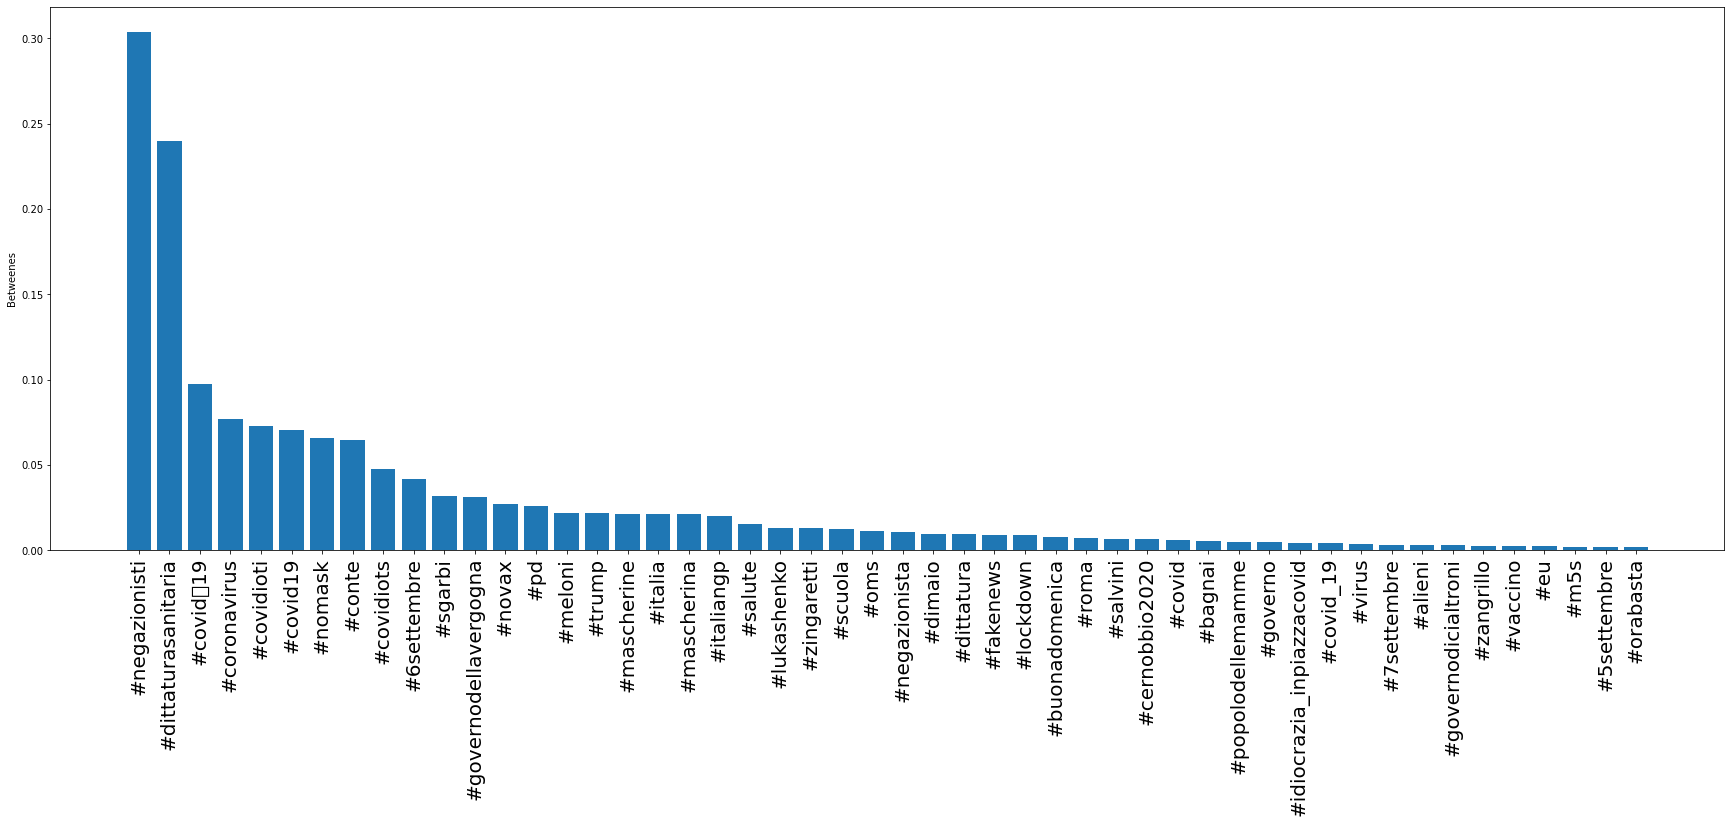

In [ ]:
bw = nx.betweenness_centrality(G_hashtag_connected)
bw_sort = {k : v for k, v in sorted(bw.items(), key = lambda t : t[1], reverse = True)}

plt.figure(figsize=(30,10))
plt.bar(list(bw_sort.keys())[0:50],height=list(bw_sort.values())[0:50])
plt.xticks(rotation=90,fontsize=20)
#plt.title("Betweenes",fontsize=20)
plt.ylabel("Betweenes")
#plt.xlabel("Nodes")
plt.show()


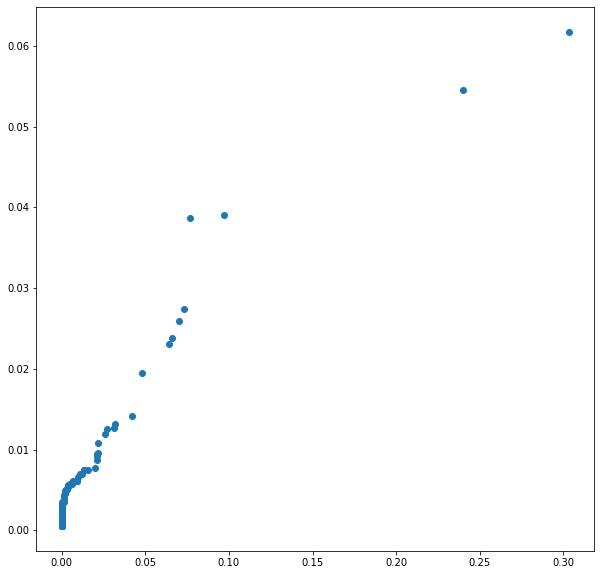

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.scatter(list(bw_sort.values()),list(pr_sort85.values()))

### Closesness

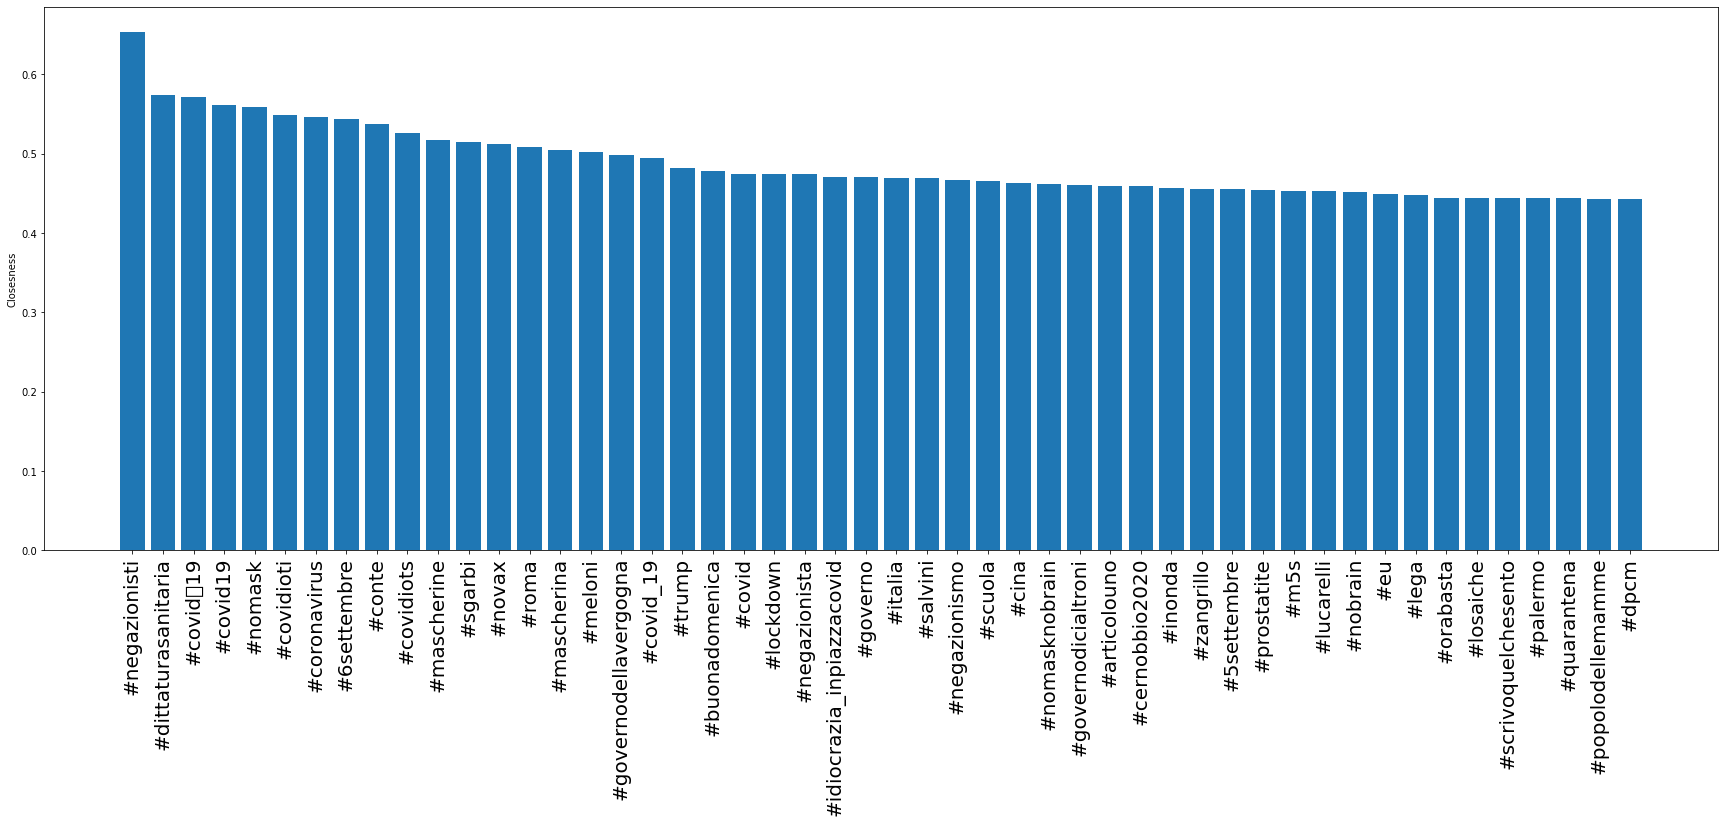

In [ ]:
close = nx.closeness_centrality(G_hashtag_connected)
close_sort = {k : v for k, v in sorted(close.items(), key = lambda t : t[1], reverse = True)}

plt.figure(figsize=(30,10))
plt.bar(list(close_sort.keys())[0:50],height=list(close_sort.values())[0:50])
plt.xticks(rotation=90,fontsize=20)
#plt.title("Closesness",fontsize=20)
plt.ylabel("Closesness")
#plt.xlabel("Nodes")
plt.show()

### Comparing Closeness, Betweenes and Pagerank

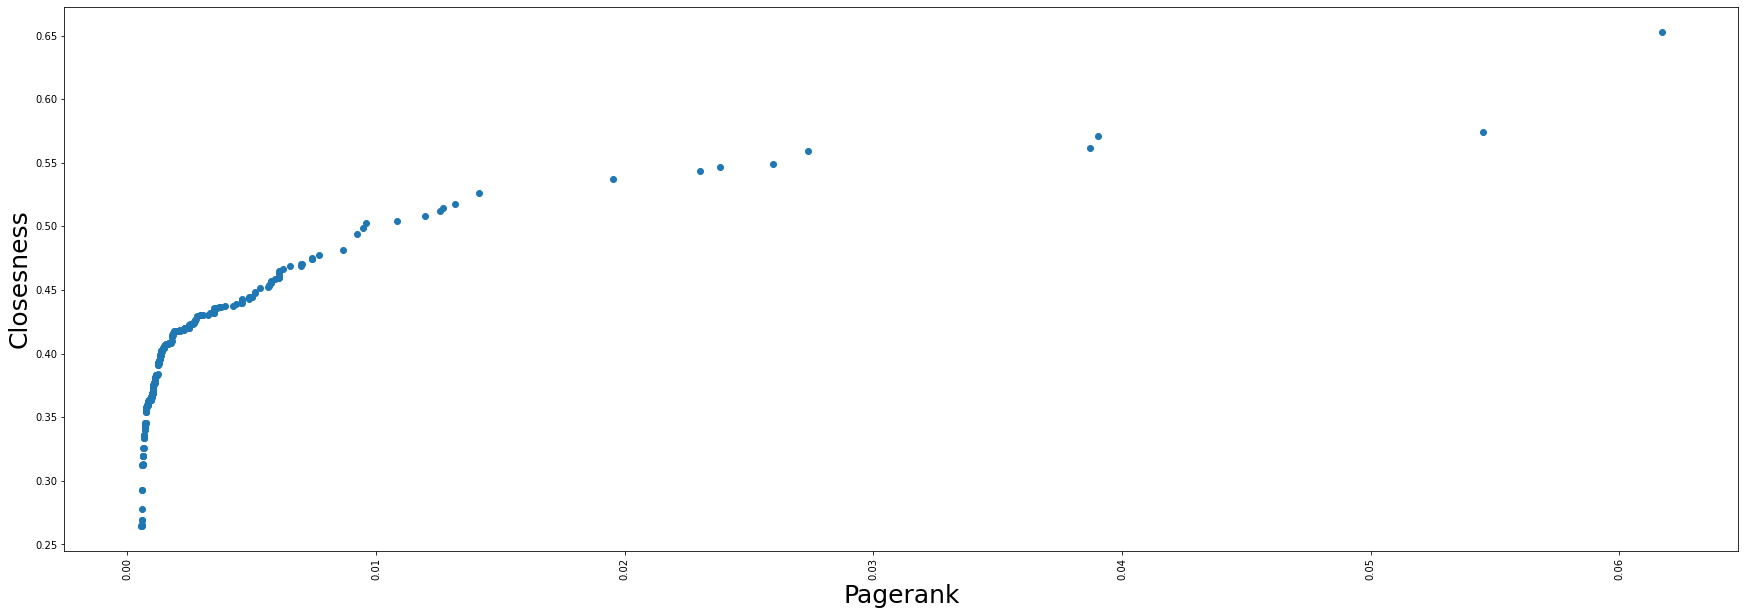

In [ ]:
plt.figure(figsize=(30,10))
plt.scatter(list(pr_sort85.values()),list(close_sort.values()))
plt.xticks(rotation=90)
plt.ylabel("Closesness", fontsize=25)
plt.xlabel("Pagerank", fontsize=25)
plt.show()

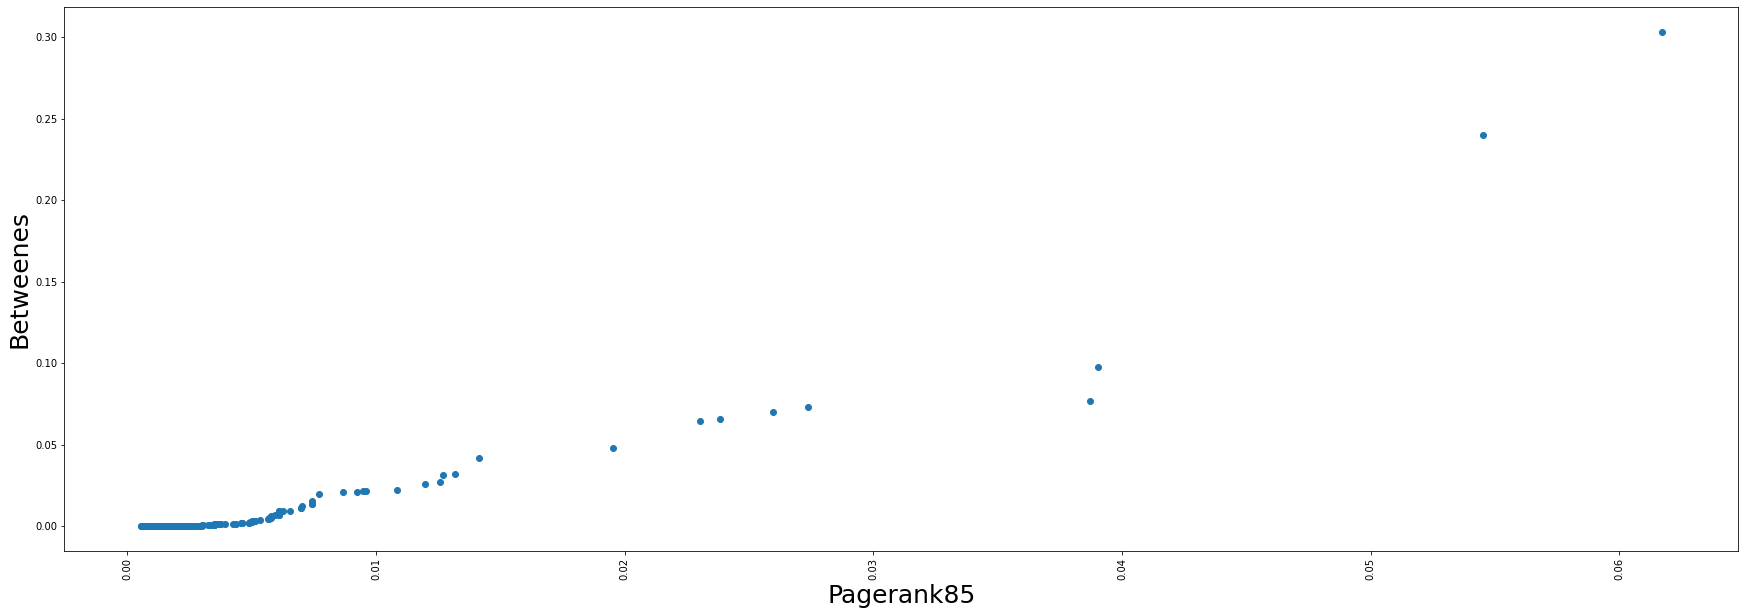

In [ ]:
plt.figure(figsize=(30,10))
plt.scatter(list(pr_sort85.values()),list(bw_sort.values()))
plt.xticks(rotation=90)
#plt.title("Betweenes vs Pagerank85",fontsize=20)
plt.ylabel("Betweenes", fontsize=25)
plt.xlabel("Pagerank", fontsize=25)
plt.show()

### Global Clustering coefficient

In [ ]:
print("Global clustering coefficient", iG_hashtag_connected.transitivity_undirected())

Global clustering coefficient 0.2866923004782894


### Local clustering coefficiet 

In [ ]:
# LOCAL CC - ARE THE NEIGHBOURS OF THE NODES ALSO CONNECTED?
import math
print("Local clustering components:")
local_ccs = iG_hashtag_connected.transitivity_local_undirected()
nodes = iG_hashtag_connected.vs()
sum_cc = 0
for local_cc in local_ccs:
    if not math.isnan(local_cc):
        sum_cc += local_cc

for node in nodes:
        
        print("   Local clustering coefficient of node",node.attributes()['_nx_name'],":",local_ccs[node.index])

        
# AVERAGE CC

print("Average clustering component", sum_cc/len(iG_hashtag_connected.vs()))


Local clustering components:
   Local clustering coefficient of node #bielorussa : 1.0
   Local clustering coefficient of node #lukashenko : 0.3333333333333333
   Local clustering coefficient of node #covidhoax : 1.0
   Local clustering coefficient of node #minsk : 1.0
   Local clustering coefficient of node #dittaturasanitaria : 0.09355787222667736
   Local clustering coefficient of node #governodellavergogna : 0.3440860215053763
   Local clustering coefficient of node #covidioti : 0.21770623742454728
   Local clustering coefficient of node #covid19 : 0.17216117216117216
   Local clustering coefficient of node #soldi : 1.0
   Local clustering coefficient of node #oms : 0.3181818181818182
   Local clustering coefficient of node #fmi : 1.0
   Local clustering coefficient of node #lukaschenko : 1.0
   Local clustering coefficient of node #covid1984 : 1.0
   Local clustering coefficient of node #libertà : 0.6190476190476191
   Local clustering coefficient of node #democrazia : 1.0
   Loca

In [ ]:
deg_dic = dict(G_hashtag_connected.degree) # keys: hashatgs, values: correspondent degree

deg_times = {}
z = []
for j in deg_dic.values():
  if j not in z:
    l = [k for k, v in deg_dic.items() if v == j]
    deg_times[j] = l
  z.append(j)

In [ ]:
deg_dic = dict(G_hashtag_connected.degree) # keys: hashatgs, values: correspondent degree

deg_times = {}
z = []
for j in deg_dic.values():
  if j not in z:
    l = [k for k, v in deg_dic.items() if v == j]
    deg_times[j] = l
  z.append(j)

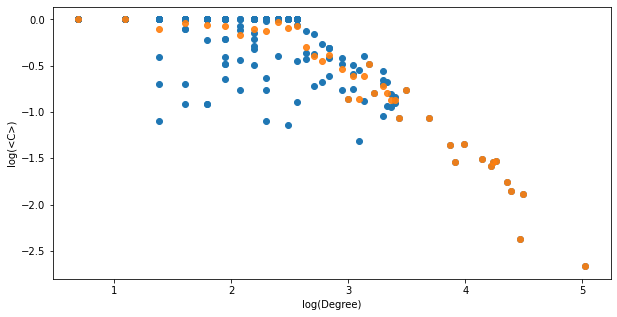

In [ ]:
# create two lists, one for the degree and another for the correspondent local clustering coefficients
local_ccs = iG_hashtag_connected.transitivity_local_undirected()
nodes = iG_hashtag_connected.vs()
x_deg = []
y_C = []
for node in nodes:
  x_deg.append(G_hashtag_connected.degree[node.attributes()['_nx_name']])
  y_C.append(local_ccs[node.index])

#-------------------------------------------------------------------------------

deg_dic = dict(G_hashtag_connected.degree) # keys: hashatgs, values: correspondent degree

deg_times = {}
z = []
for j in deg_dic.values():
  if j not in z:
    l = [k for k, v in deg_dic.items() if v == j]
    deg_times[j] = l
  z.append(j)

# create a list with the average clustering coeffcients for each degree
y_C_mean = []
for i in range(len(deg_times.keys())):
  y_C_mean.append(nx.average_clustering(G_hashtag_connected, nodes=list(deg_times.values())[i]))

# create a list of the degree that we have in our network
x_deg_mean = []
for i in range(len(deg_times.keys())):
  x_deg_mean.append(list(deg_times.keys())[i])

#-------------------------------------------------------------------------------

# PLOT

fig = plt.figure(figsize = (10, 5))
 
# creating the scatter plot
plt.scatter(np.log(x_deg), np.log(y_C))
plt.scatter(np.log(x_deg_mean), np.log(y_C_mean),  alpha=0.9)

plt.xlabel("log(Degree)")
plt.ylabel("log(<C>)")
#plt.title("Clustering Coefficient")
plt.show()

In [ ]:
print(r"The Average CLustering Coefficient for the G_hashtag_connected is:", nx.average_clustering(G_hashtag_connected))

The Average CLustering Coefficient for the G_hashtag_connected is: 0.8690848605041689


### Assortativity

In [ ]:
print(f"The assortativity of the network: {nx.degree_assortativity_coefficient(G_hashtag_connected)}")

The assortativity of the network: -0.21507473536699218


In [ ]:
deg_dic = dict(G_hashtag_connected.degree) # keys: hashatgs, values: correspondent degree

# make a dictionary with degree:list of hash -> ex. {2:['#something', '#something_else'],...}
deg_times = {}
z = []
for j in deg_dic.values():
  if j not in z:
    l = [k for k, v in deg_dic.items() if v == j]
    deg_times[j] = l
  z.append(j)

In [ ]:
x_degree = []
y_av_neigh = []
for k in deg_times.keys():
  for x in deg_times[k]:
    x_degree.append(k)
    y_av_neigh.append(nx.average_neighbor_degree(G_hashtag_connected)[x])

#-------------------------------------------------------------------------------

x_degree_mean = []
y_av_mean = []
for k in deg_times.keys():
  x_degree_mean.append(k)
  o = []
  for x in deg_times[k]:
    o.append(nx.average_neighbor_degree(G_hashtag_connected)[x])
  y_av_mean.append(np.mean(o))

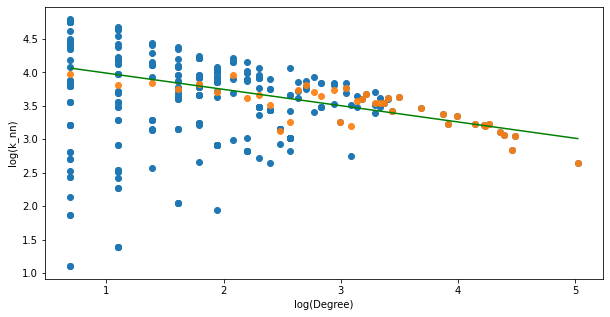

In [ ]:
# PLOT

fig = plt.figure(figsize = (10, 5))
 
# creating the scatter plot
plt.scatter(np.log(x_degree), np.log(y_av_neigh))
plt.scatter(np.log(x_degree_mean), np.log(y_av_mean),  alpha=0.9)

x = np.log(x_degree_mean)
y = np.log(y_av_mean)

m, b = np.polyfit(x, y, 1)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 'green')
plt.xlabel("log(Degree)")
plt.ylabel("log(k_nn)")

plt.show()

### Comunities detection

In [ ]:
cummunities = {}
for i in np.linspace(1,60,5):
  cummunities[i] = nx_comm.louvain_communities(G_hashtag_connected,resolution=1,seed=int(i))


In [ ]:
salva = True
for i in cummunities:
  print(len(cummunities[i]))
  if salva:
    best_com = cummunities[i]
    salva = False
  for j in cummunities[i]:
      print(j)
  print("\t")

10
{'#covidhoax', '#lukashenko', '#bielorussa', '#minsk'}
{'#covidiots', '#governodellavergogna', '#medici', '#truffacovid', '#libertà', '#traditori', '#covid1984', '#pdr', '#vaccine', '#mascherine', '#schiavitù', '#hongkong', '#primagliitaliani', '#nonnamaura', '#pensiero', '#schiavi', '#maicolpd', '#primogiornodiscuola', '#buonsabato', '#comitatotecnicoscientifico', '#democrazia', '#ritornoschiavitù', '#orabasta', '#trumanshow', '#ribelliamoci', '#contagio', '#covid_19', '#libero', '#scuola2020', '#milanmonza', '#dittatura', '#scuolaparentale', '#fascidacompatimento', '#istruzioneparentale', '#popolodellemamme', '#noisiamoiquattrogattidelpopolobue', '#scrivoquelchesento', '#tampone', '#siamotutticinesi', '#covidioti', '#infami', '#dittaturasanitaria', '#nuovoordinemondiale', '#losaiche', '#bielorussia'}
{'#anticovid', '#sociale', '#democratica', '#fmi', '#psichico', '#soldi', '#salute', '#fisico', '#oms', '#lukaschenko'}
{'#italiaviva', '#evanescence', '#eu', '#covid19', '#dem', '#em

In [ ]:
for i in cummunities:
      print("Modularity:")
      print(nx_comm.modularity(G_hashtag_connected,cummunities[i]))
      print("\t")


Modularity:
0.6389063981447135
	
Modularity:
0.6396953148473149
	
Modularity:
0.6401408736345167
	
Modularity:
0.6381328403765539
	
Modularity:
0.6425488742295686
	


### Make the pagerank on the single comunities and analyze the tweets

In [ ]:
best_com
comunity_network = {}
counter = 1
for i in best_com:
  comm = list(i)
  up_weighted_hashtag_prevax = []
  for i in range(edge_prevax.shape[0]):
    if (edge_prevax.iloc[i,0] in comm) and (edge_prevax.iloc[i,1] in comm):
      up_weighted_hashtag_prevax.append((edge_prevax.iloc[i,0],edge_prevax.iloc[i,1],edge_prevax.iloc[i,2]))
  G_com = nx.Graph()
  G_com.add_weighted_edges_from(up_weighted_hashtag_prevax)
  pr = nx.pagerank(G_com)
  pr = list({k : v for k, v in sorted(pr.items(), key = lambda t : t[1], reverse = True)}.keys())[:9]
  comunity_network[counter] = pr
  counter +=1

In [ ]:
pd.Series(comunity_network).to_csv("/content/drive/MyDrive/Network_Science_covid_project/An_com/hashtag_prevaxcamp.csv")

In [ ]:
counter = 1
list_of_text_com = []
for i in comunity_network.values():
    for index, row in tweets_filtered.iterrows():
      if type(row["hashtags"]) is list:
        for j in row["hashtags"]:
          if j in i:
            list_of_text_com.append({"comunità":counter,"text":row["text"]})
      if type(row["hashtags"]) is str:
        if row["hashtags"]==j:
          list_of_text_com.append({"comunità":counter,"text":row["text"]})
    counter+=1

In [ ]:
test_comunity_text = pd.DataFrame(list_of_text_com,index=[i for i in range(len(list_of_text_com))])

In [ ]:
test_comunity_text.drop_duplicates(inplace=True)

In [ ]:
test_comunity_text.shape

(3753, 2)

In [ ]:
test_comunity_text.to_csv("/content/drive/MyDrive/Network_Science_covid_project/An_com/text_prevaxcamp.csv")

### Robustness (if we are able)

In [ ]:
import random

def robustness(g):

    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_giantcomponentnodes = []
    luppolo=0

    for x in range(g.number_of_nodes()):
        best_node = nx.nodes(g_remove_most_important)
        best_node2 = []
        for n in best_node:
            best_node2.append(n)

        best_node = random.choice(best_node2)

        if x % 5 == 0:
          luppolo +=1
          comps = list(nx.connected_components(g_remove_most_important))
          
          giant_comp = max(comps, key=len)
          comp_nodes_number = len(giant_comp)
          comp_len = len(comps)

          list_giantcomponentnodes.append(comp_nodes_number)
          list_components.append(comp_len)
          list_removed.append(x)

        g_remove_most_important.remove_nodes_from([best_node])
    return list_removed, list_giantcomponentnodes




def attack(g):

    most_imp = pd.Series(dict(g.degree)).sort_values(ascending=False)
    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_giantcomponentnodes = []
    for x in range(g.number_of_nodes()):
        best_node = nx.nodes(g_remove_most_important)
        best_node2 = []
        for n in best_node:
            best_node2.append(n)

        best_node = most_imp.index[x]
        comps = list(nx.connected_components(g_remove_most_important))
        giant_comp = max(comps, key=len)
        comp_nodes_number = len(giant_comp)
        comp_len = len(comps)

        list_giantcomponentnodes.append(comp_nodes_number)
        list_components.append(comp_len)
        list_removed.append(x)
        g_remove_most_important.remove_nodes_from([best_node])
    return list_removed, list_giantcomponentnodes

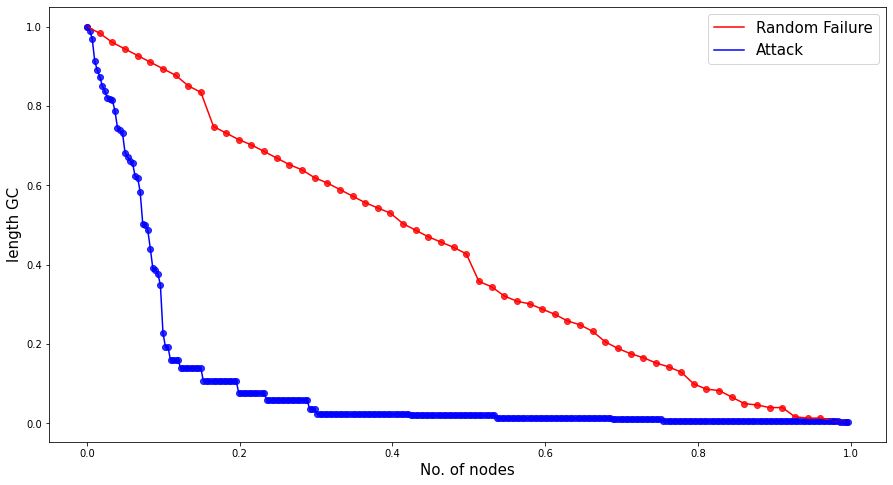

In [ ]:
x_rob, y_rob = robustness(G_hashtag_connected)
x_att, y_att = attack(G_hashtag_connected)

x_att = np.array(x_att)/G_hashtag_connected.number_of_nodes()
x_rob = np.array(x_rob)/G_hashtag_connected.number_of_nodes()
y_rob = np.array(y_rob)/G_hashtag_connected.number_of_nodes()
y_att = np.array(y_att)/G_hashtag_connected.number_of_nodes()

fig = plt.figure(figsize=(15,8))
ran = plt.scatter(x=x_rob, y=y_rob, 
                 color='red', alpha=0.8)
plt.plot(x_rob, y_rob, color='red', label='Random Failure')
  
att = plt.scatter(x=x_att, y=y_att, 
                 color='blue', alpha=0.8)
plt.plot(x_att, y_att, color='blue', label='Attack')
#plt.title('Robustness Pre vacination campaign', fontsize=25)
plt.xlabel("No. of nodes", fontsize=15)
plt.ylabel("length GC", fontsize=15)
plt.legend(prop={'size': 15})

# *Working on Network, words* 

In this part we will start analyzing the netwrok propiety


## We really need all the nodes? Probably not but let's see 

#### Instead to re run evrything we import the edgelist


In [ ]:
up_weighted_hashtag_prevax = []
edge_words = pd.read_csv('/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_words_prevaxcamp.csv',header=None)
for i in range(edge_words.shape[0]):
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_hashtag_prevax.append((edge_words.iloc[i,0],edge_words.iloc[i,1],edge_words.iloc[i,2]))

G_hybrid = nx.Graph()
G_hybrid.add_weighted_edges_from(up_weighted_hashtag_prevax)

### Pagerank 

Ascending and descending

	 	 	 	 	 	 	 	 	 Pagerank with different alpha
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


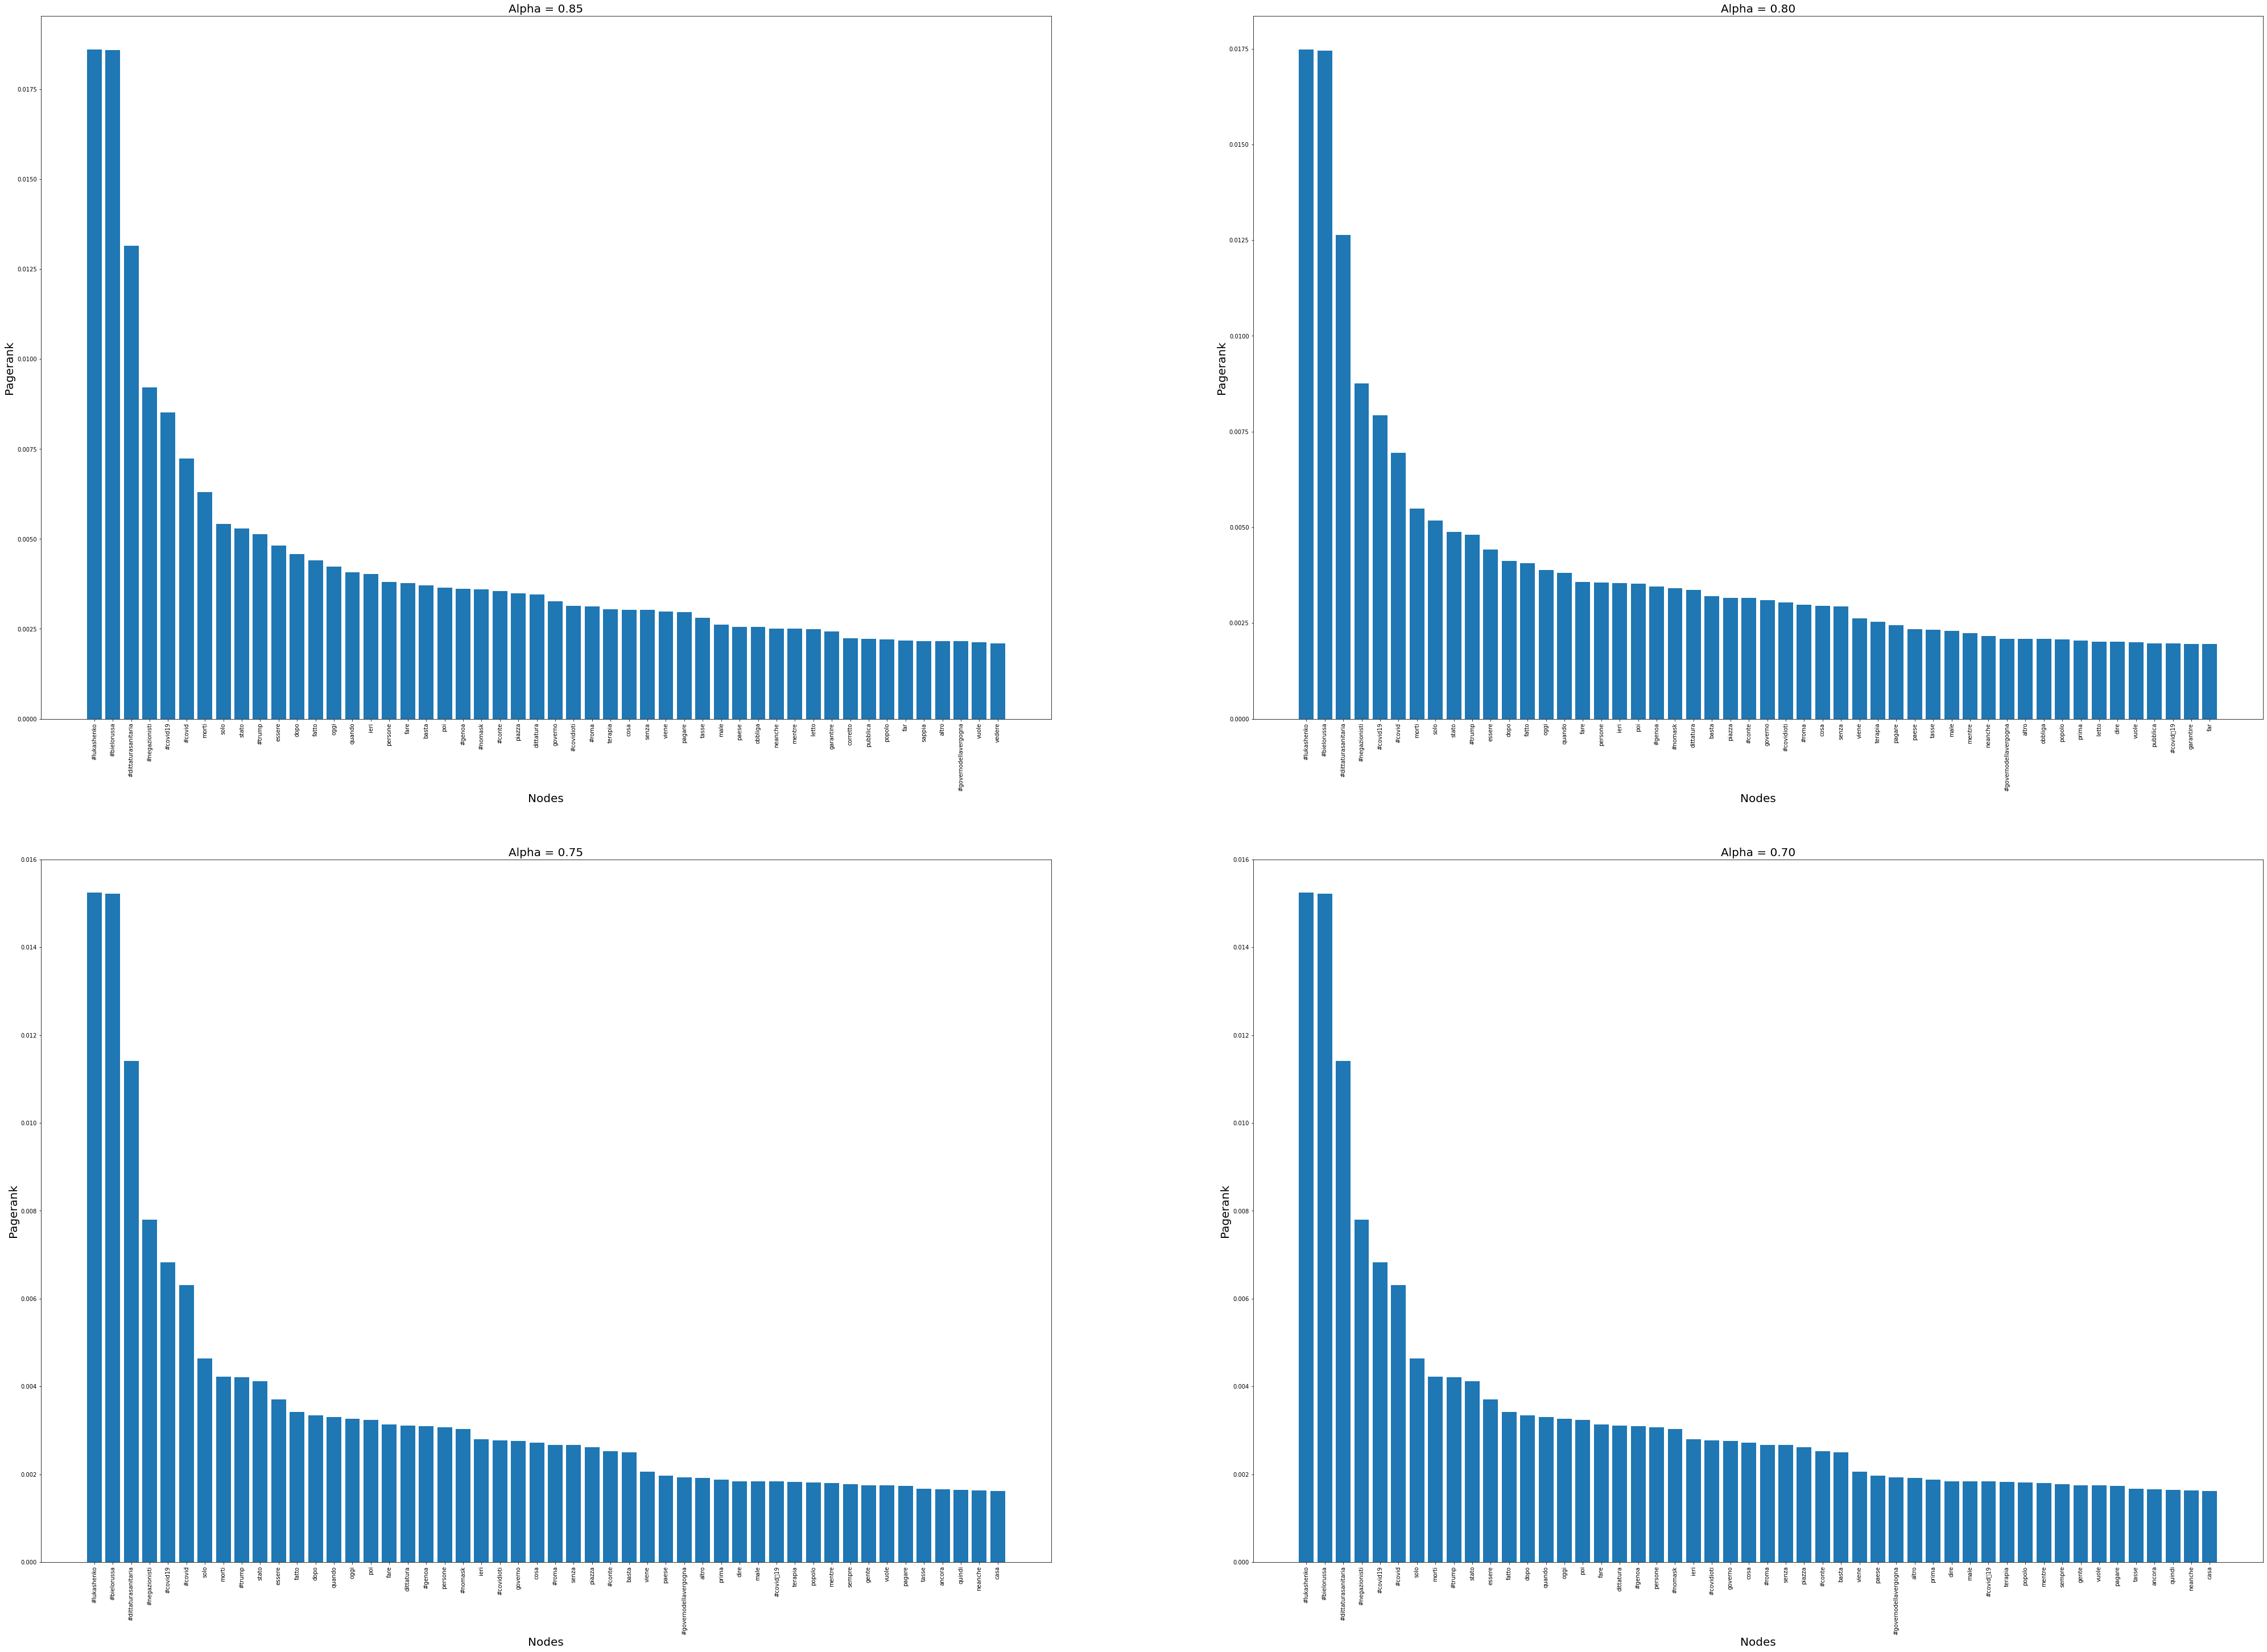

In [ ]:
## Try different teletrasportation :)
print("\t \t \t \t \t \t \t \t \t Pagerank with different alpha")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
pr70 = nx.pagerank(G_hybrid,alpha=0.70)
pr_sort70 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr75 = nx.pagerank(G_hybrid,alpha=0.75)
pr_sort75 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr80 = nx.pagerank(G_hybrid,alpha=0.80)
pr_sort80 = {k : v for k, v in sorted(pr80.items(), key = lambda t : t[1], reverse = True)}

pr85= nx.pagerank(G_hybrid,alpha=0.85,max_iter=100000)
pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = True)}


fig, ax = plt.subplots(2, 2,figsize=(70,50))

ax[0,0].bar(list(pr_sort85.keys())[0:50],height=list(pr_sort85.values())[0:50])
ax[0,0].tick_params(axis='x',labelrotation=90)
ax[0,0].set_ylabel('Pagerank',fontsize = 20)
ax[0,0].set_xlabel('Nodes',fontsize = 20)
ax[0,0].set_title("Alpha = 0.85",fontsize = 20)

ax[0,1].bar(list(pr_sort80.keys())[0:50],height=list(pr_sort80.values())[0:50])
ax[0,1].tick_params(axis='x',labelrotation=90)
ax[0,1].set_ylabel('Pagerank',fontsize = 20)
ax[0,1].set_xlabel('Nodes',fontsize = 20)
ax[0,1].set_title("Alpha = 0.80",fontsize = 20)

ax[1,0].bar(list(pr_sort75.keys())[0:50],height=list(pr_sort75.values())[0:50])
ax[1,0].tick_params(axis='x',labelrotation=90)
ax[1,0].set_ylabel('Pagerank',fontsize = 20)
ax[1,0].set_xlabel('Nodes',fontsize = 20)
ax[1,0].set_title("Alpha = 0.75",fontsize = 20)

ax[1,1].bar(list(pr_sort70.keys())[0:50],height=list(pr_sort70.values())[0:50])
ax[1,1].tick_params(axis='x',labelrotation=90)
ax[1,1].set_ylabel('Pagerank',fontsize = 20)
ax[1,1].set_xlabel('Nodes',fontsize = 20)
ax[1,1].set_title("Alpha = 0.70",fontsize = 20)
plt.show()


	 	 	 	 	 	 	 	 	 Pagerank with different alpha
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


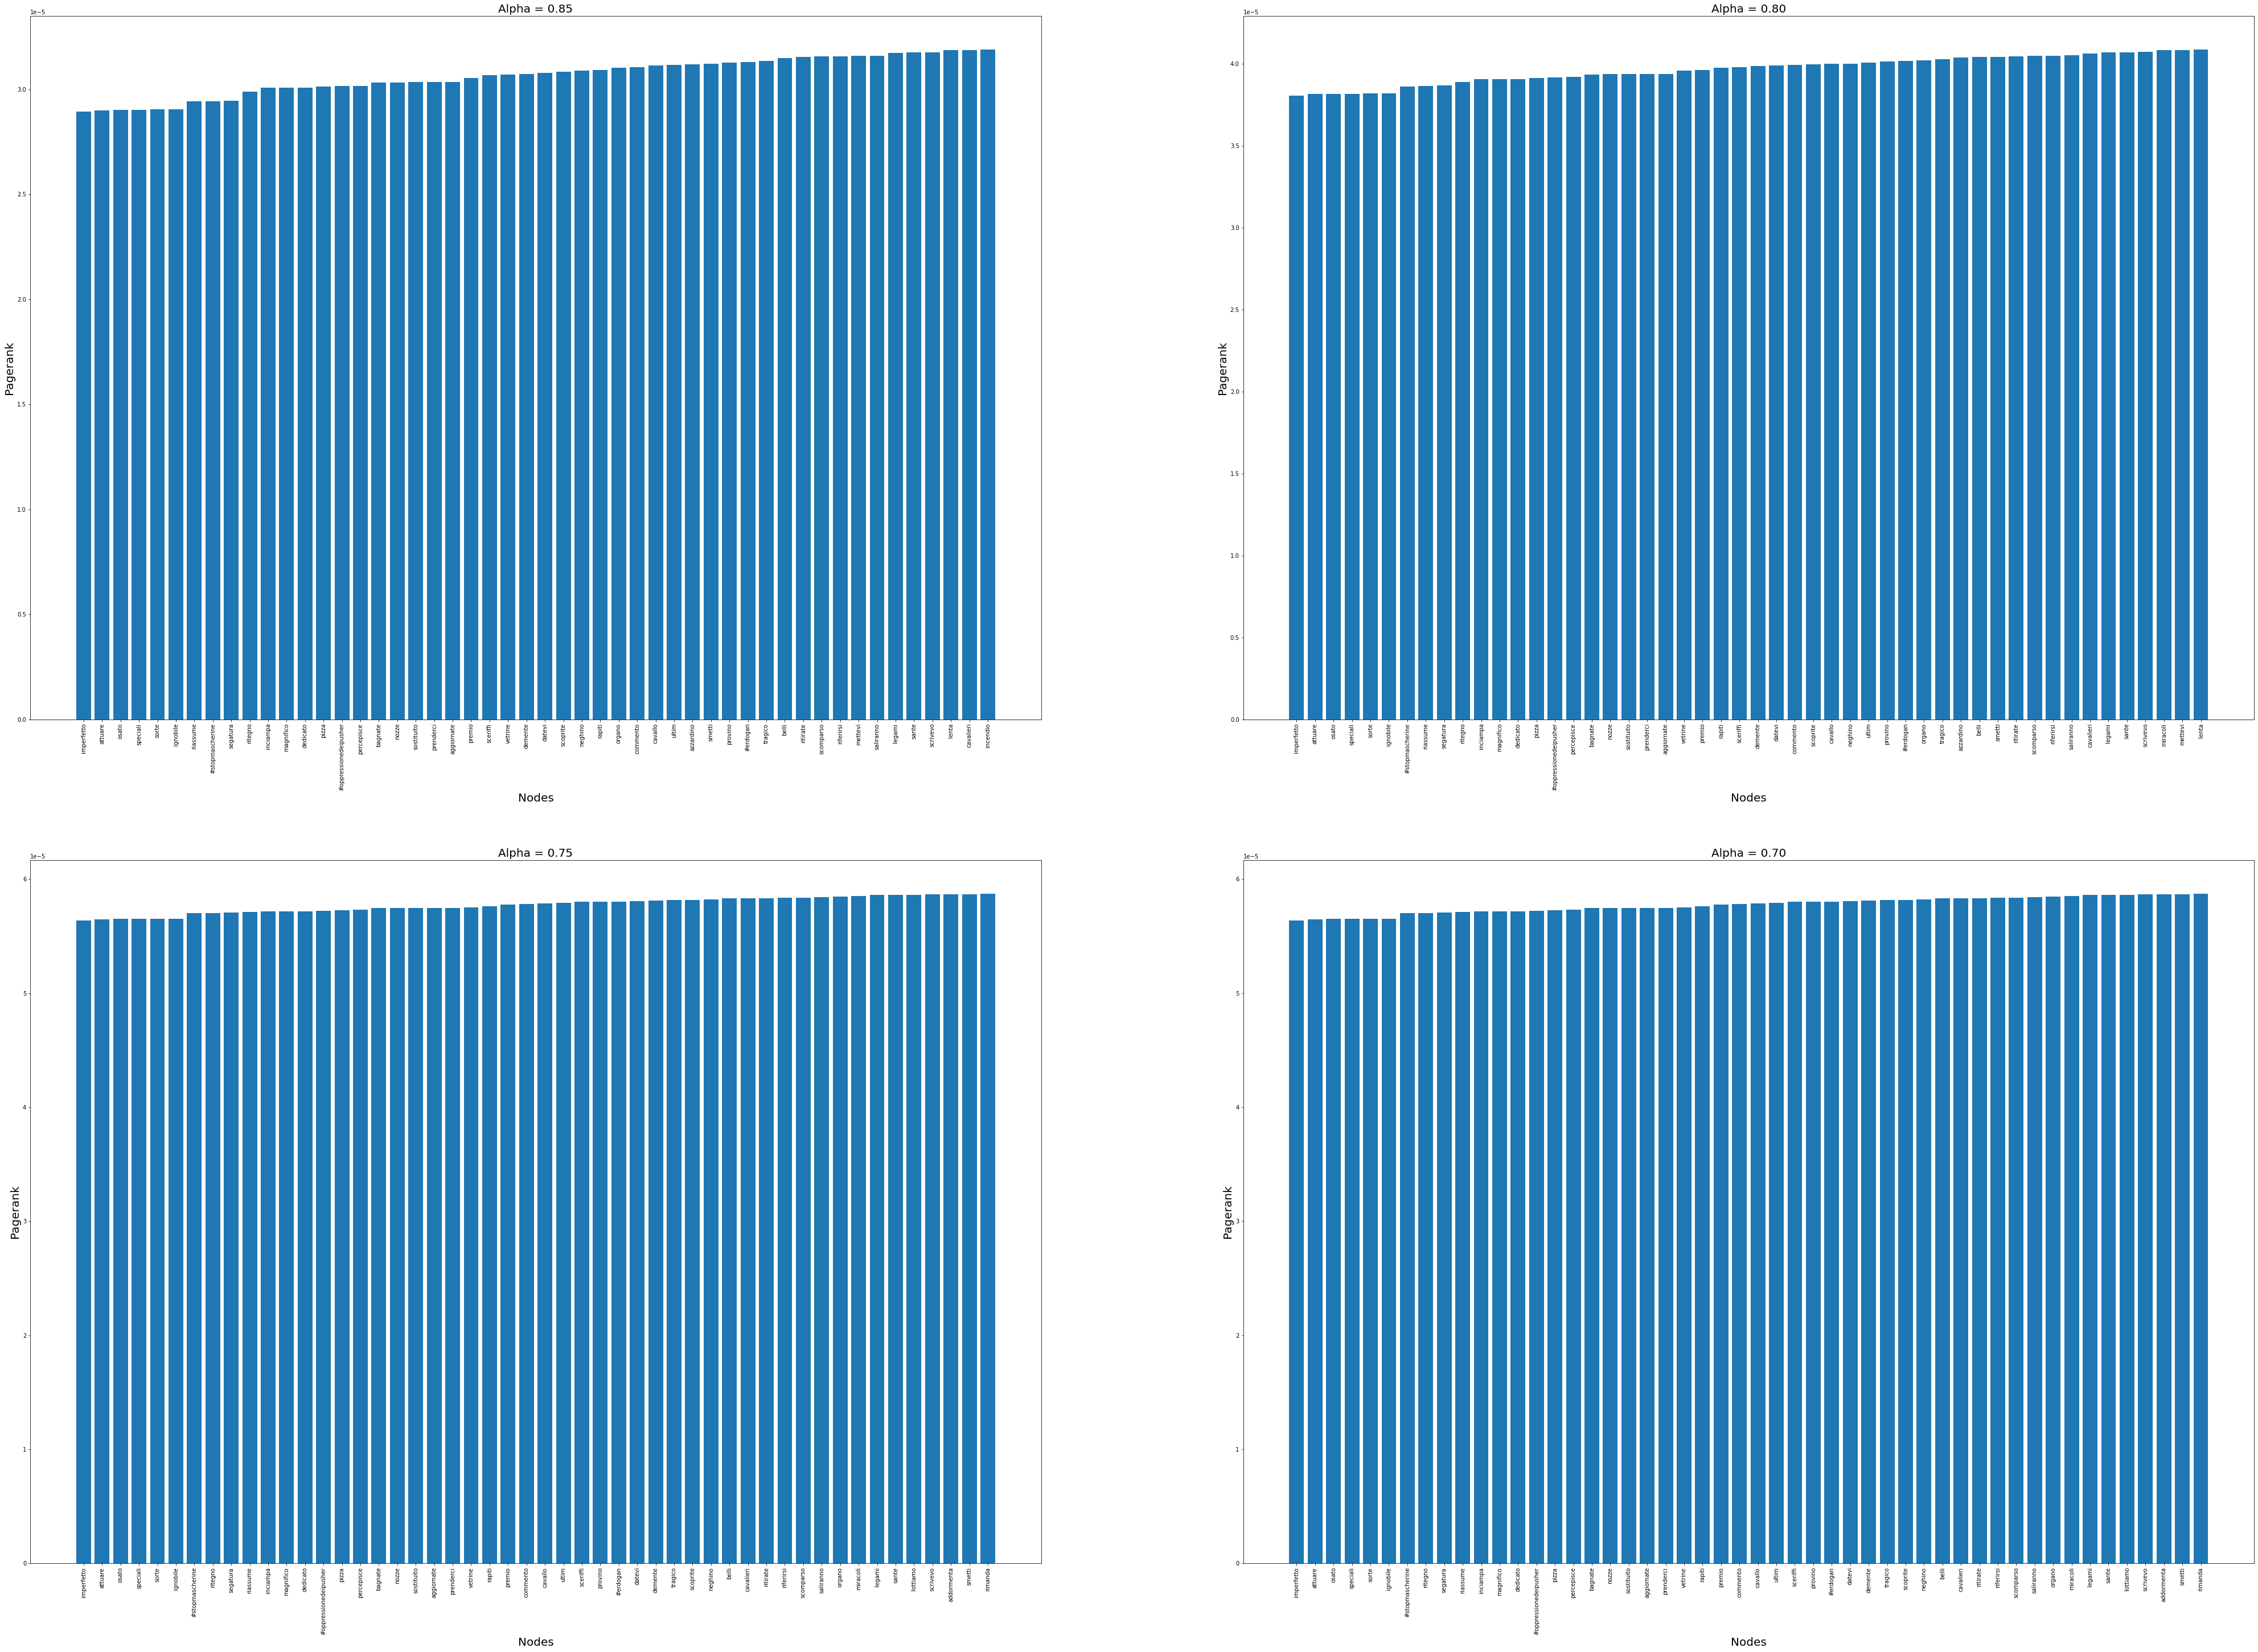

In [ ]:
## Try different teletrasportation :)
print("\t \t \t \t \t \t \t \t \t Pagerank with different alpha")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
pr70 = nx.pagerank(G_hybrid,alpha=0.70)
pr_sort70 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = False)}

pr75 = nx.pagerank(G_hybrid,alpha=0.75)
pr_sort75 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = False)}

pr80 = nx.pagerank(G_hybrid,alpha=0.80)
pr_sort80 = {k : v for k, v in sorted(pr80.items(), key = lambda t : t[1], reverse = False)}

pr85= nx.pagerank(G_hybrid,alpha=0.85,max_iter=100000)
pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = False)}


fig, ax = plt.subplots(2, 2,figsize=(70,50))

ax[0,0].bar(list(pr_sort85.keys())[0:50],height=list(pr_sort85.values())[0:50])
ax[0,0].tick_params(axis='x',labelrotation=90)
ax[0,0].set_ylabel('Pagerank',fontsize = 20)
ax[0,0].set_xlabel('Nodes',fontsize = 20)
ax[0,0].set_title("Alpha = 0.85",fontsize = 20)

ax[0,1].bar(list(pr_sort80.keys())[0:50],height=list(pr_sort80.values())[0:50])
ax[0,1].tick_params(axis='x',labelrotation=90)
ax[0,1].set_ylabel('Pagerank',fontsize = 20)
ax[0,1].set_xlabel('Nodes',fontsize = 20)
ax[0,1].set_title("Alpha = 0.80",fontsize = 20)

ax[1,0].bar(list(pr_sort75.keys())[0:50],height=list(pr_sort75.values())[0:50])
ax[1,0].tick_params(axis='x',labelrotation=90)
ax[1,0].set_ylabel('Pagerank',fontsize = 20)
ax[1,0].set_xlabel('Nodes',fontsize = 20)
ax[1,0].set_title("Alpha = 0.75",fontsize = 20)

ax[1,1].bar(list(pr_sort70.keys())[0:50],height=list(pr_sort70.values())[0:50])
ax[1,1].tick_params(axis='x',labelrotation=90)
ax[1,1].set_ylabel('Pagerank',fontsize = 20)
ax[1,1].set_xlabel('Nodes',fontsize = 20)
ax[1,1].set_title("Alpha = 0.70",fontsize = 20)
plt.show()


### Node degree

Ascending and descending

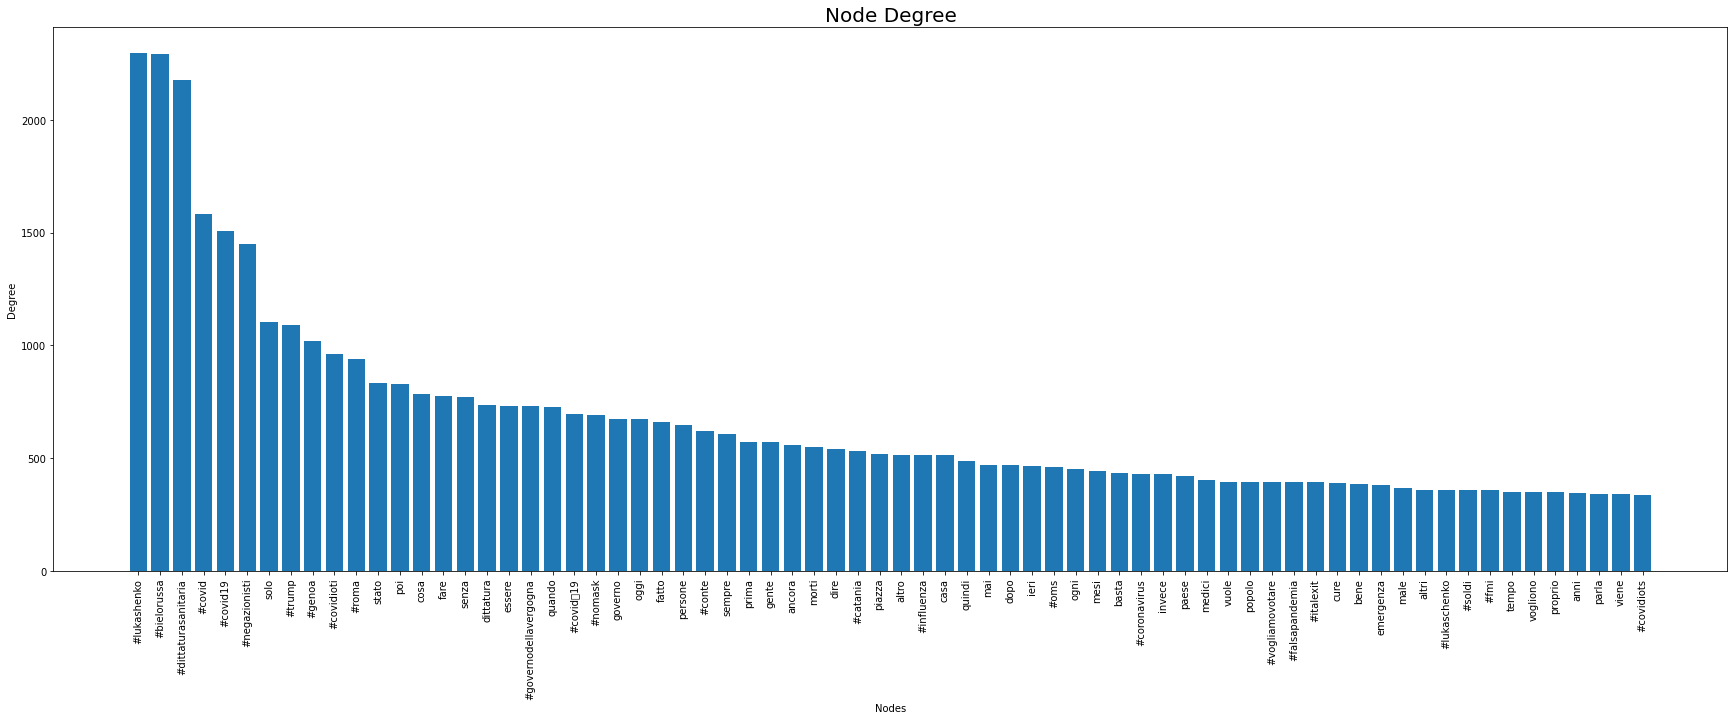

In [ ]:
most_imp = pd.Series(dict(G_hybrid.degree)).sort_values(ascending=False)[:70]
plt.figure(figsize=(30,10))
plt.bar(most_imp.index,height=most_imp)
plt.xticks(rotation=90)
plt.title("Node Degree",fontsize=20)
plt.ylabel("Degree",fontsize=10)
plt.xlabel("Nodes",fontsize=10)
plt.show()

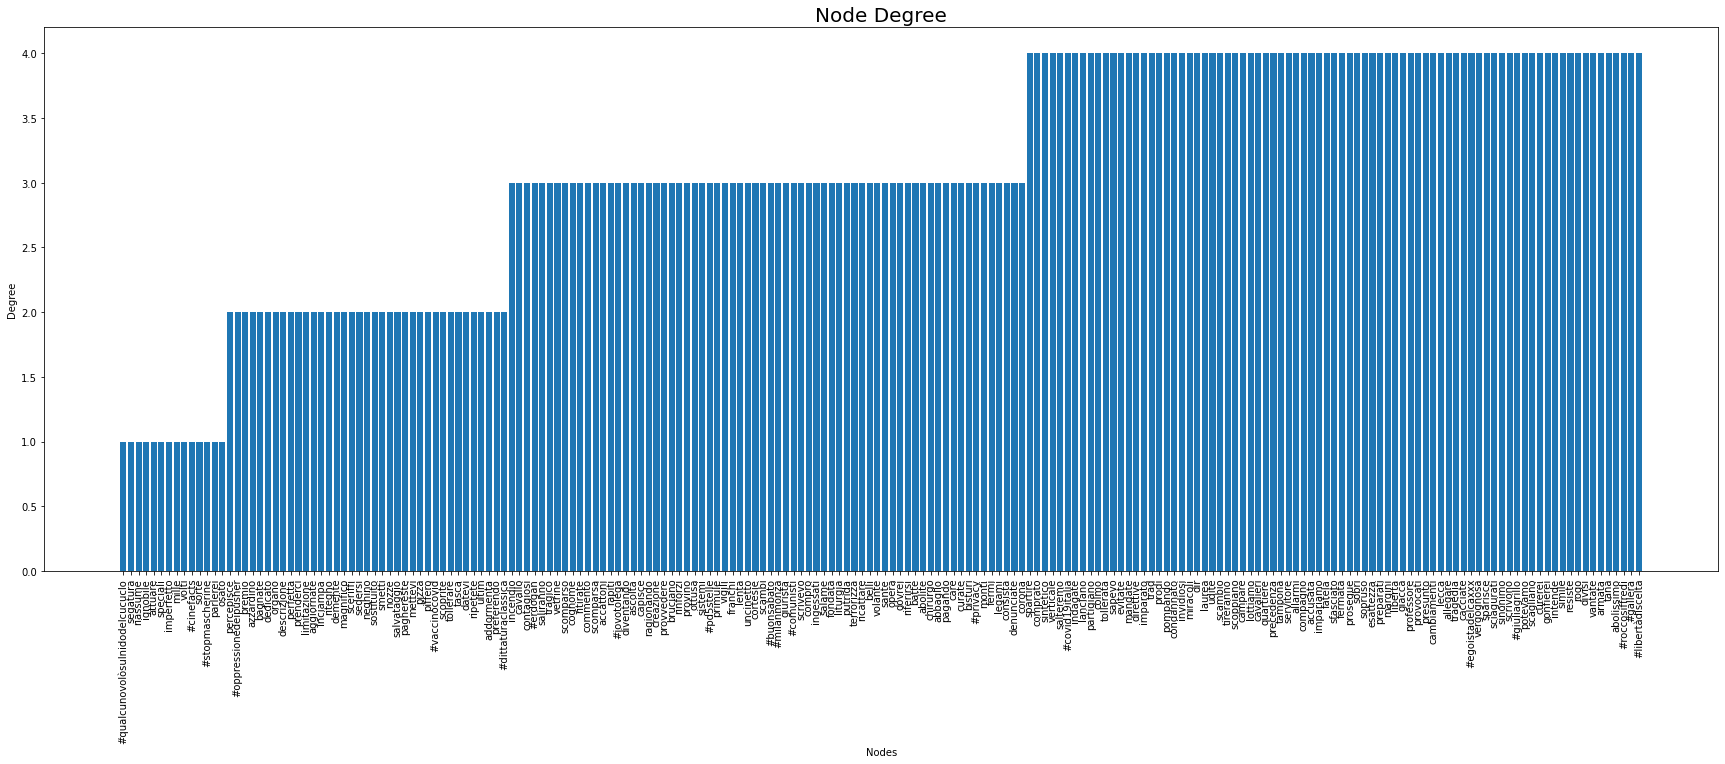

In [ ]:
less_imp = pd.Series(dict(G_hybrid.degree)).sort_values(ascending=True)[:200]
plt.figure(figsize=(30,10))
plt.bar(less_imp.index,height=less_imp)
plt.xticks(rotation=90)
plt.title("Node Degree",fontsize=20)
plt.ylabel("Degree",fontsize=10)
plt.xlabel("Nodes",fontsize=10)
plt.show()

In [ ]:
blacklist = list(most_imp[(most_imp>5000)].index)
blacklist.extend(list(less_imp[(less_imp<2)].index))
blacklist

['#qualcunovolòsulnidodelcucuclo',
 'segatura',
 'riassume',
 'ignobile',
 'attuare',
 'speciali',
 'imperfetto',
 'mille',
 'volti',
 '#cinefacts',
 'sorte',
 '#stopmascherine',
 'parlerei',
 'osato']

## As we can notice the first 2 node have a really high frequqncy, node degree & Pagerank

So we will discard them because think about the com. detect. Also the node with a small degree and 

In [ ]:
up_weighted_hashtag_prevax = []
edge_words = pd.read_csv('/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_words_prevaxcamp.csv',header=None)
for i in range(edge_words.shape[0]):
  if (edge_words.iloc[i,0] not in blacklist) and(edge_words.iloc[i,1] not in blacklist):
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_hashtag_prevax.append((edge_words.iloc[i,0],edge_words.iloc[i,1],edge_words.iloc[i,2]))

G_hybrid = nx.Graph()
G_hybrid.add_weighted_edges_from(up_weighted_hashtag_prevax)

In [ ]:
filename_prevax = "/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_words_prevaxcamp.csv"
nx.write_weighted_edgelist(G_hybrid, filename_prevax, delimiter=",")

### The network is connected? (If not wich are tha connected componets)

In [ ]:
iG_prevax = ig.Graph.from_networkx(G_hybrid)
print("\t \t \t \t \t \t  \t \t \t  CONNECTION")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Is the graph connected:","YES" if iG_prevax.is_connected() else "NO")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("The connected componet are:")
print("\t")
#IF NOT YOU CAN FIND ISOLATED COMPONENENTS
skip = True 
isolated = {}
i = 1
for component in iG_prevax.components():
  print(component)
  if not skip:
    isolated[i] = component
    i+=1
  skip =False
print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  


	 	 	 	 	 	  	 	 	  CONNECTION
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pandas.core.common import flatten
isolated_list = list(flatten(list(isolated.values())))
isolated_list
temp = [len(i) for i in isolated.values()]
find_the_comunities = dict(zip([i+1 for i in range(len(isolated.keys()))],temp))

In [ ]:
counter = 0
find_counter = 1
check_com = 0
isolated = []
print("\t \t \t  Hashtag of the connected component")
print("--------------------------------------------------------------------------------------------")
for vertice in iG_prevax.vs:
    if counter in isolated_list:
      if check_com==find_the_comunities[find_counter]:
        print("--------------------------------------------------------------------------------------------")
        find_counter+=1
        check_com=0
      isolated.append(vertice.attributes()['_nx_name'])
      print(f" The hashtag {vertice.attributes()['_nx_name'].upper()}, is in the isolated component number: {find_counter}")
      check_com+=1
    counter+=1
print("--------------------------------------------------------------------------------------------")

	 	 	  Hashtag of the connected component
--------------------------------------------------------------------------------------------
 The hashtag BRUTTI, is in the isolated component number: 1
 The hashtag SCIAGURATI, is in the isolated component number: 1
 The hashtag ARMATA, is in the isolated component number: 1
 The hashtag CELESTE, is in the isolated component number: 1
 The hashtag PORTIAMO, is in the isolated component number: 1
--------------------------------------------------------------------------------------------


In [ ]:
up_weighted_hashtag_connected = []
edge_words = pd.read_csv("/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_words_prevaxcamp.csv",header=None)
index_comp_con = []
for i in range(edge_words.shape[0]):
      if (edge_words.iloc[i,0] not in isolated) and (edge_words.iloc[i,1] not in isolated) and (edge_words.iloc[i,2]>0) and not (edge_words.iloc[i,1] in blacklist) and not (edge_words.iloc[i,0] in blacklist):
        #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
        #if(network[edge])>1: 
        up_weighted_hashtag_connected.append((edge_words.iloc[i,0],edge_words.iloc[i,1],edge_words.iloc[i,2]))
        index_comp_con.append(i)
      
G_hybrid_connected= nx.Graph()
G_hybrid_connected.add_weighted_edges_from(up_weighted_hashtag_connected)

In [ ]:
edge_words.iloc[index_comp_con,:].to_csv("/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_words_clean_prevaxcamp.csv",header=None)

In [ ]:
edge_words.iloc[index_comp_con,:]

,0,1,2
0,#bielorussa,#lukashenko,2040
1,#bielorussa,volere,2
2,#bielorussa,chiedere,3
3,#bielorussa,aiuto,8
4,#bielorussa,vampiro,2
...,...,...,...
114180,#twitter,#shadowban,1
114181,#twitter,negativa,1
114182,#shadowban,negativa,1
114183,#egoistadelcaxxx,sinonimo,1


## Working on the giant Network component

#### Instead to re run evrything we import the edgelist


In [ ]:
up_weighted_hashtag_prevax = []
edge_words = pd.read_csv("/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_words_clean_prevaxcamp.csv",header=None).iloc[:,1:]
for i in range(edge_words.shape[0]):
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted_hashtag_prevax.append((edge_words.iloc[i,0],edge_words.iloc[i,1],edge_words.iloc[i,2]))

G_hybrid_connected = nx.Graph()
G_hybrid_connected.add_weighted_edges_from(up_weighted_hashtag_prevax)

In [ ]:
filename_prevax = "/content/drive/MyDrive/Network_Science_covid_project/Pre_Vax_Camp/edge_words_clean_connected.csv"
nx.write_weighted_edgelist(G_hybrid_connected, filename_prevax, delimiter=",")

In [ ]:
iG_hybrid_connected = ig.Graph.from_networkx(G_hybrid_connected)

#### Network diameter

In [ ]:
# DIAMETER - HOW FAR ARE THE TWO MOST DISTANT NODES

print("Network diameter:", iG_hybrid_connected.diameter(directed=False))

# GET NODES IN THE DIAMETER PATH 
diameter_path = []
d = iG_prevax.get_diameter()
for i in range(0, iG_hybrid_connected.diameter()):
  diameter_path.append((d[i], d[i+1]))
# GET EDGES IN THE DIAMETER PATH
diameter_edges = iG_prevax.get_eids(pairs=diameter_path, directed=False)


# AVERAGE PATH LENGTH - HOW CLOSE ARE THE NODES TO EACH OTHER ON AVERAGE

print("Average path length:", iG_hybrid_connected.average_path_length(directed=False))

Network diameter: 5
Average path length: 2.427922547571425


### Node degree

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


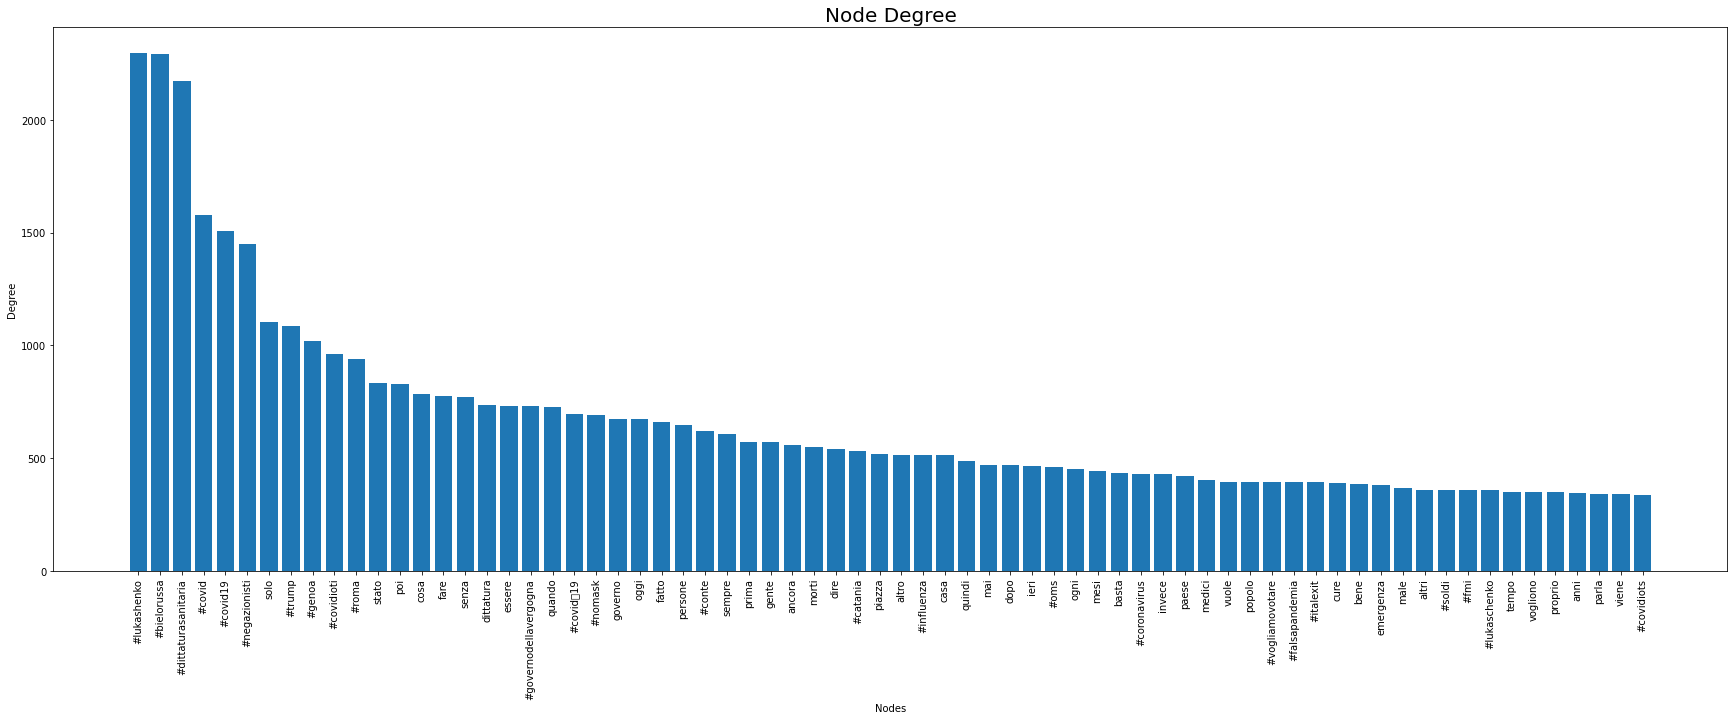

In [ ]:
most_imp = pd.Series(dict(G_hybrid_connected.degree)).sort_values(ascending=False)[:70]
plt.figure(figsize=(30,10))
plt.bar(most_imp.index,height=most_imp)
plt.xticks(rotation=90)
plt.title("Node Degree",fontsize=20)
plt.ylabel("Degree",fontsize=10)
plt.xlabel("Nodes",fontsize=10)
plt.show()

### Degree distribution and Gamma estimation

In [ ]:
A = nx.adjacency_matrix(G_hybrid_connected)
d = np.sum(A,1)
d = np.squeeze(np.asarray(d))
d = d[d>0]
k = np.unique(d)
pk = np.histogram(d,k)[0]
pk = pk/np.sum(pk)
Pk = 1-np.cumsum(pk)

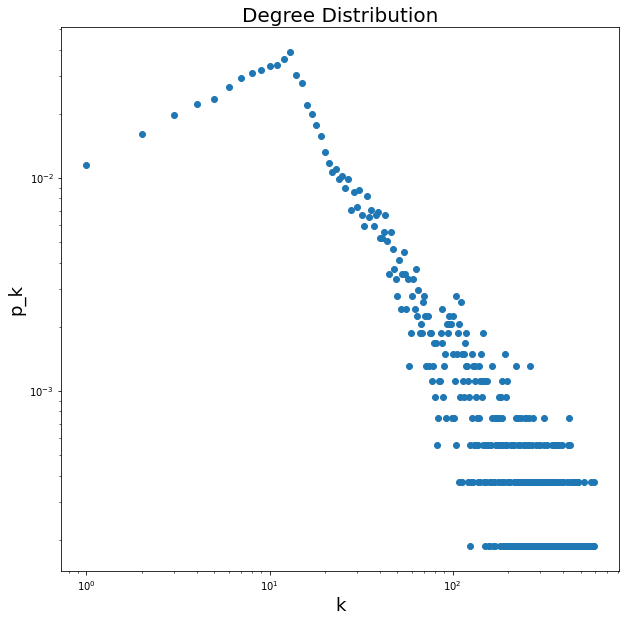

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.loglog(pk,'o')
plt.title("Degree Distribution",size=20)
plt.xlabel("k",size=18)
plt.ylabel("p_k",size=18)
plt.show()

In [ ]:
####### Gamma estimation
print("\t \t Gamma estimation (Free scale or random graph")
print("-------------------------------------------------------------------------")
d2 = d[d>=k.min()]
gamma = 1 + np.mean(np.log(d2/k.min()))
print(f"Gamma with the k min selected as the smallest neighbours, so k={k.min()}")
print(f"Gamma = {gamma}")
d2 = d[d>=5e1]
gamma = 1 + np.mean(np.log(d2/3e1))
print("-------------------------------------------------------------------------")
print(f"Gamma with the k min wisely selected, using the plot above, so k={3e1}")
print(f"Gamma = {gamma}")
print("-------------------------------------------------------------------------")

	 	 Gamma estimation (Free scale or random graph
-------------------------------------------------------------------------
Gamma with the k min selected as the smallest neighbours, so k=2
Gamma = 3.7425964307809902
-------------------------------------------------------------------------
Gamma with the k min wisely selected, using the plot above, so k=30.0
Gamma = 2.7587666951704586
-------------------------------------------------------------------------



### Pagerank 

	 	 	 	 	 	 	 	 	 Pagerank with different alpha
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


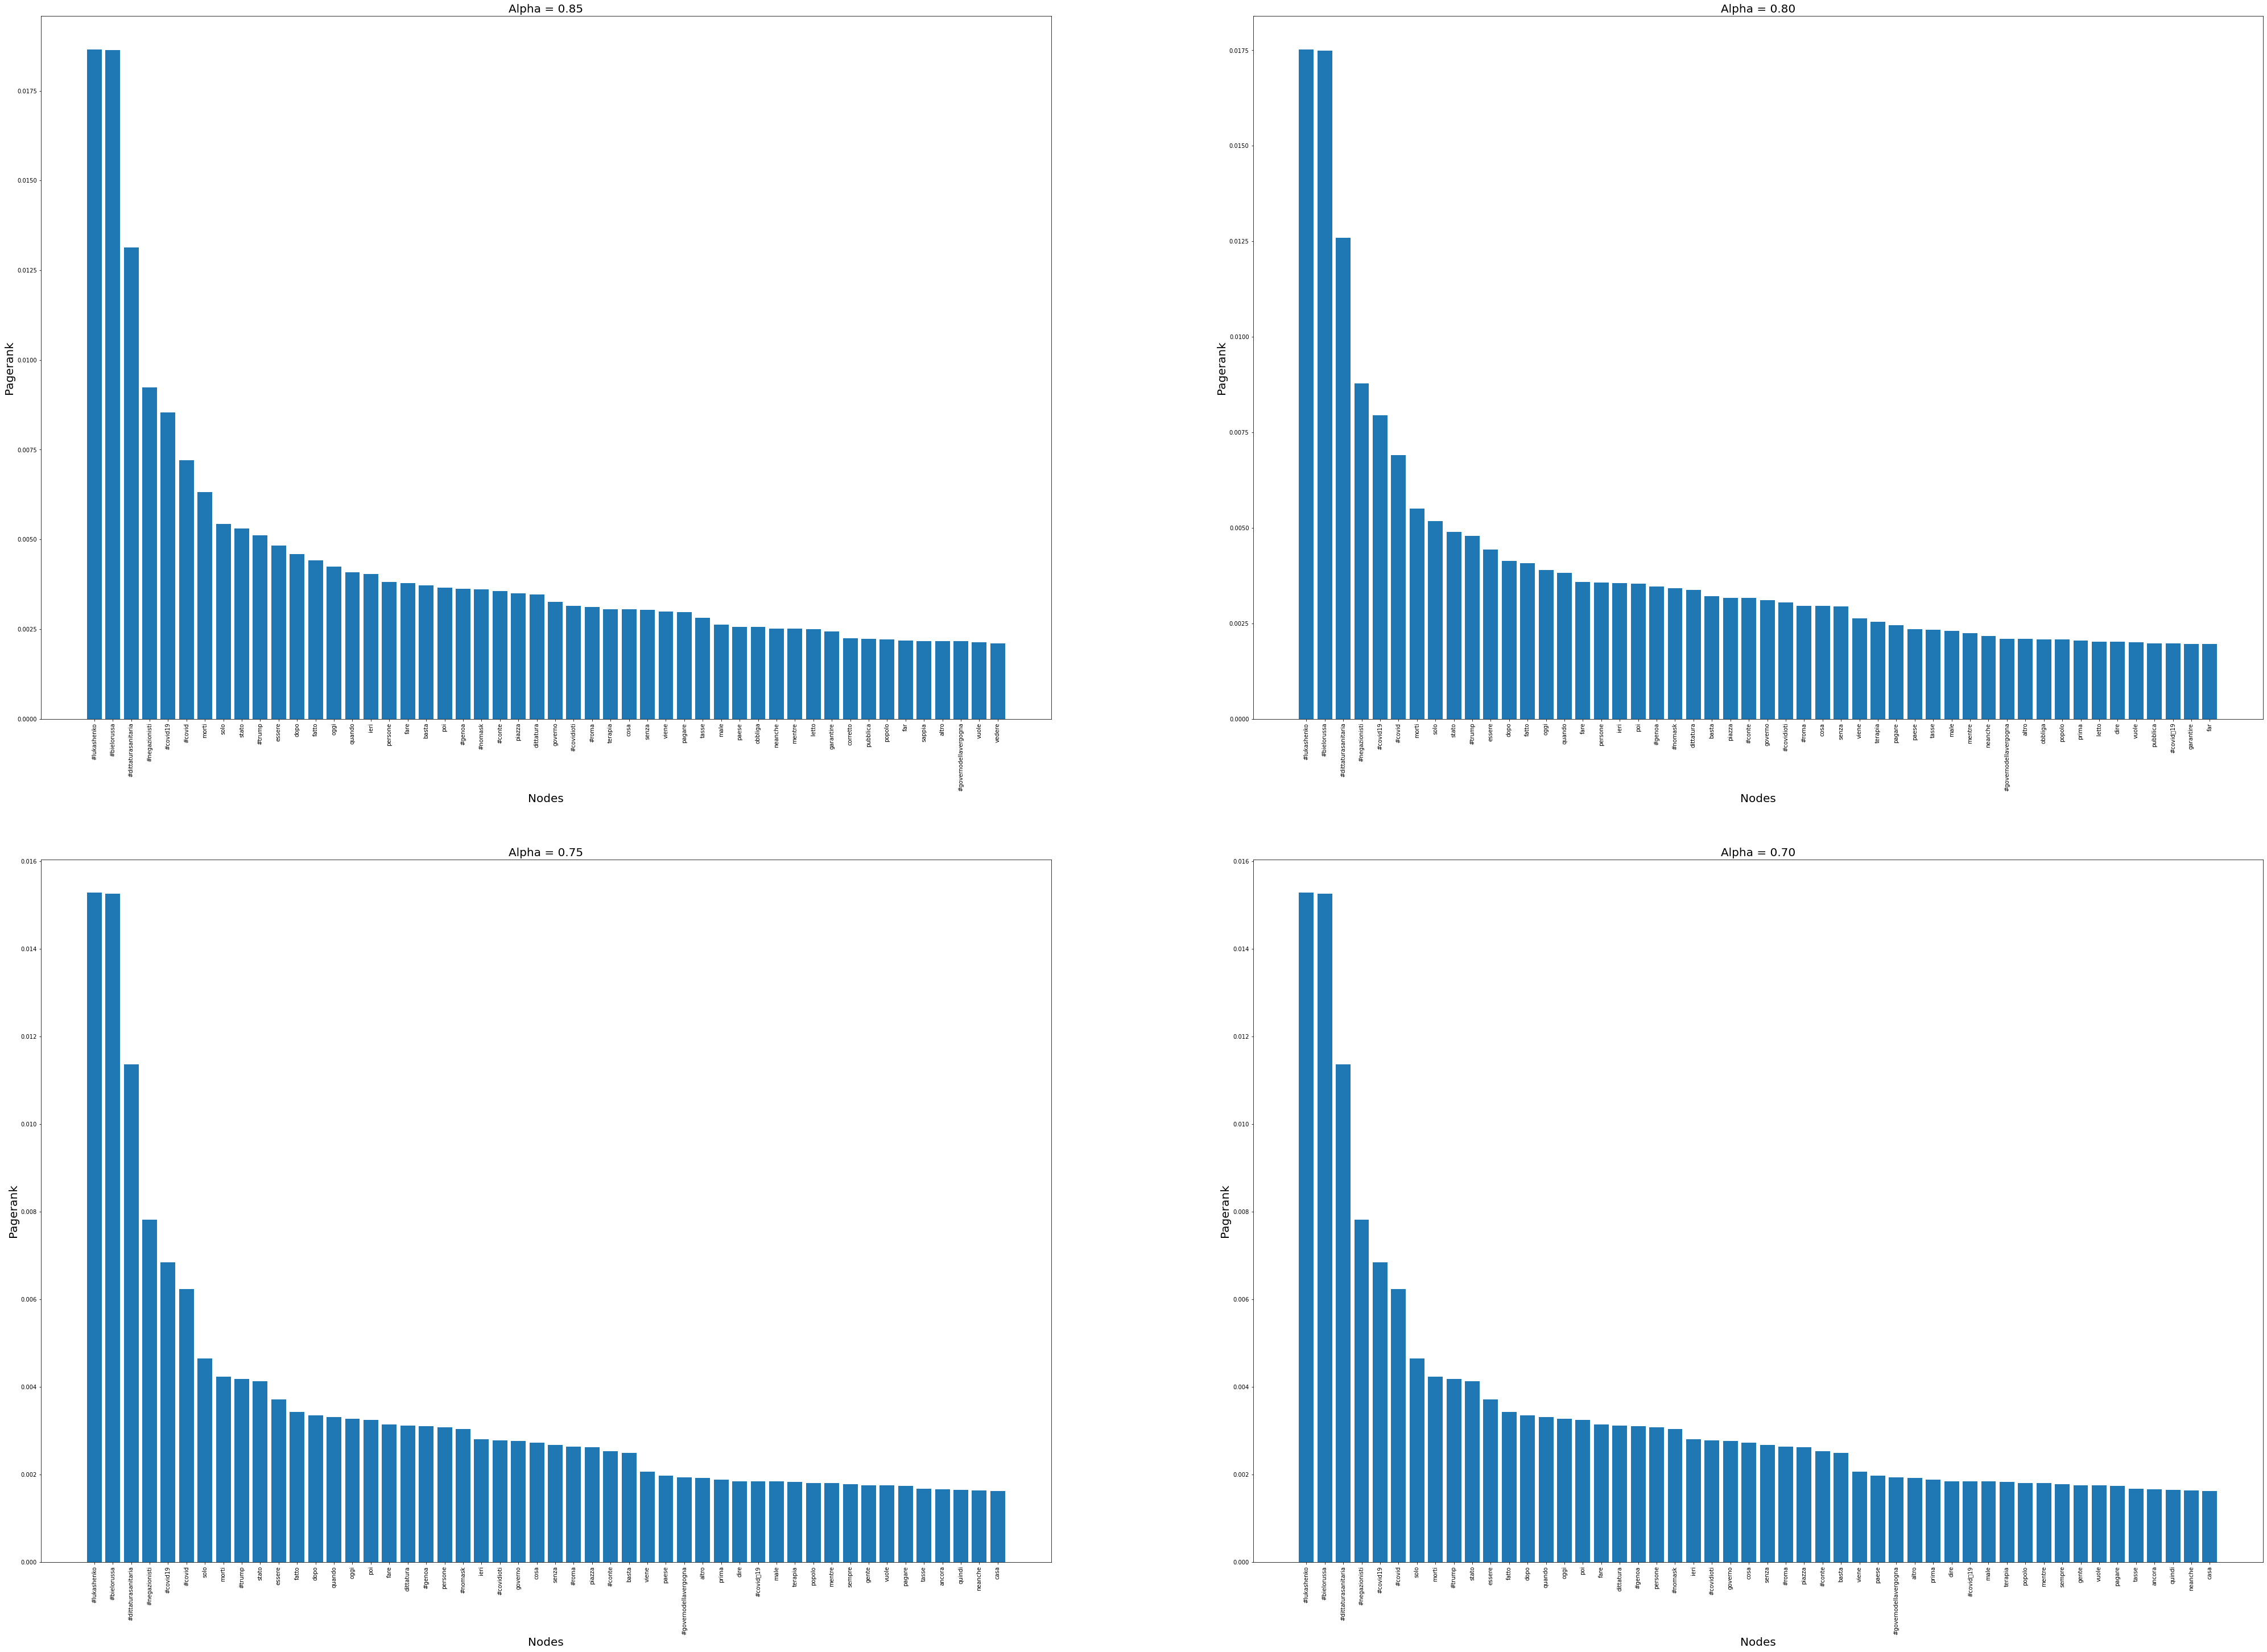

In [ ]:
## Try different teletrasportation :)
print("\t \t \t \t \t \t \t \t \t Pagerank with different alpha")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
pr70 = nx.pagerank(G_hybrid_connected,alpha=0.70)
pr_sort70 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr75 = nx.pagerank(G_hybrid_connected,alpha=0.75)
pr_sort75 = {k : v for k, v in sorted(pr70.items(), key = lambda t : t[1], reverse = True)}

pr80 = nx.pagerank(G_hybrid_connected,alpha=0.80)
pr_sort80 = {k : v for k, v in sorted(pr80.items(), key = lambda t : t[1], reverse = True)}

pr85= nx.pagerank(G_hybrid_connected,alpha=0.85,max_iter=100000)
pr_sort85 = {k : v for k, v in sorted(pr85.items(), key = lambda t : t[1], reverse = True)}


fig, ax = plt.subplots(2, 2,figsize=(70,50))

ax[0,0].bar(list(pr_sort85.keys())[0:50],height=list(pr_sort85.values())[0:50])
ax[0,0].tick_params(axis='x',labelrotation=90)
ax[0,0].set_ylabel('Pagerank',fontsize = 20)
ax[0,0].set_xlabel('Nodes',fontsize = 20)
ax[0,0].set_title("Alpha = 0.85",fontsize = 20)

ax[0,1].bar(list(pr_sort80.keys())[0:50],height=list(pr_sort80.values())[0:50])
ax[0,1].tick_params(axis='x',labelrotation=90)
ax[0,1].set_ylabel('Pagerank',fontsize = 20)
ax[0,1].set_xlabel('Nodes',fontsize = 20)
ax[0,1].set_title("Alpha = 0.80",fontsize = 20)

ax[1,0].bar(list(pr_sort75.keys())[0:50],height=list(pr_sort75.values())[0:50])
ax[1,0].tick_params(axis='x',labelrotation=90)
ax[1,0].set_ylabel('Pagerank',fontsize = 20)
ax[1,0].set_xlabel('Nodes',fontsize = 20)
ax[1,0].set_title("Alpha = 0.75",fontsize = 20)

ax[1,1].bar(list(pr_sort70.keys())[0:50],height=list(pr_sort70.values())[0:50])
ax[1,1].tick_params(axis='x',labelrotation=90)
ax[1,1].set_ylabel('Pagerank',fontsize = 20)
ax[1,1].set_xlabel('Nodes',fontsize = 20)
ax[1,1].set_title("Alpha = 0.70",fontsize = 20)
plt.show()


### Betweenes

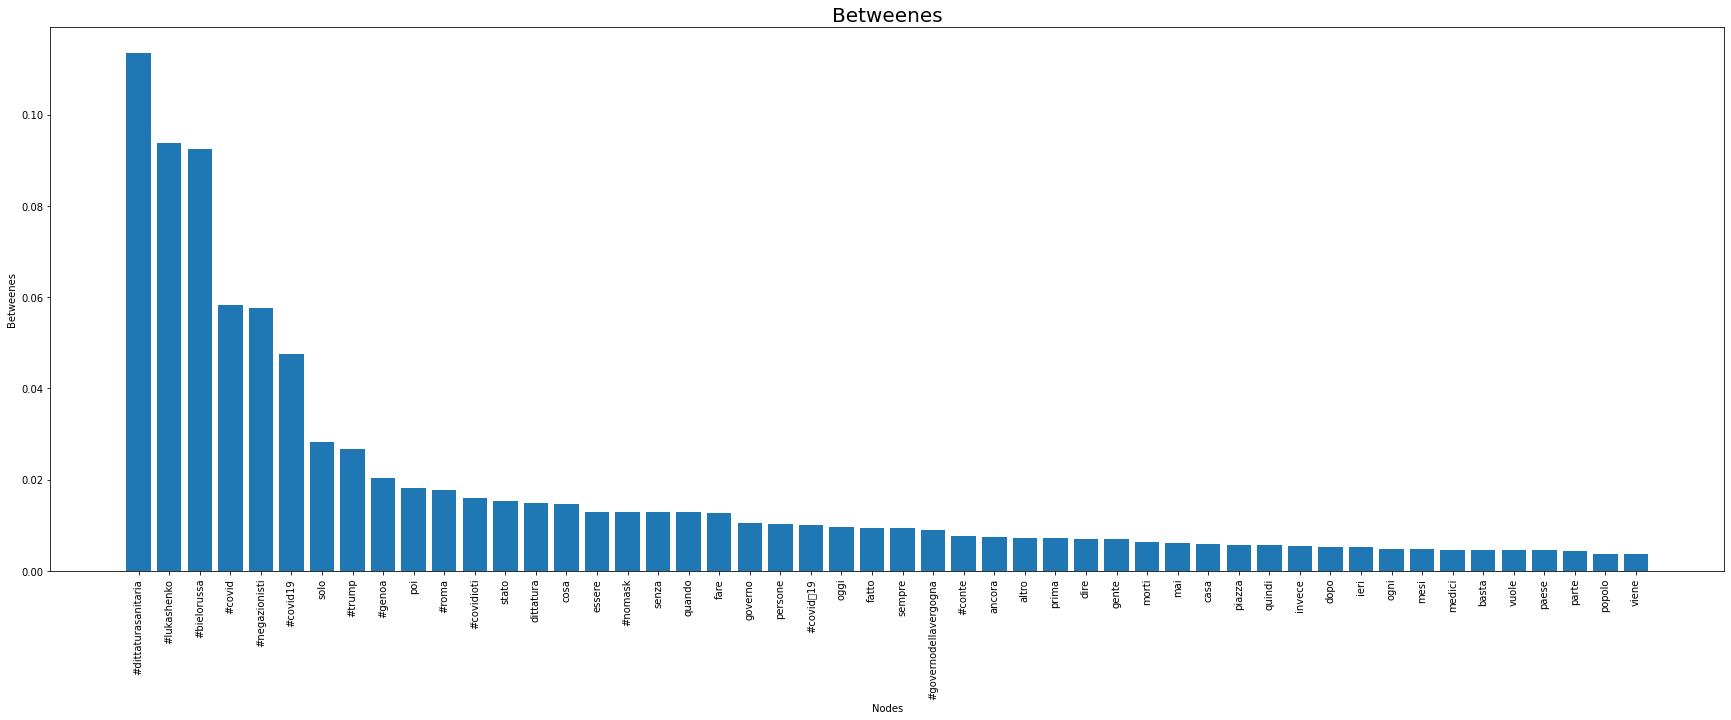

In [ ]:
bw = nx.betweenness_centrality(G_hybrid_connected)
bw_sort = {k : v for k, v in sorted(bw.items(), key = lambda t : t[1], reverse = True)}

plt.figure(figsize=(30,10))
plt.bar(list(bw_sort.keys())[0:50],height=list(bw_sort.values())[0:50])
plt.xticks(rotation=90)
plt.title("Betweenes",fontsize=20)
plt.ylabel("Betweenes")
plt.xlabel("Nodes")
plt.show()


### Closesness

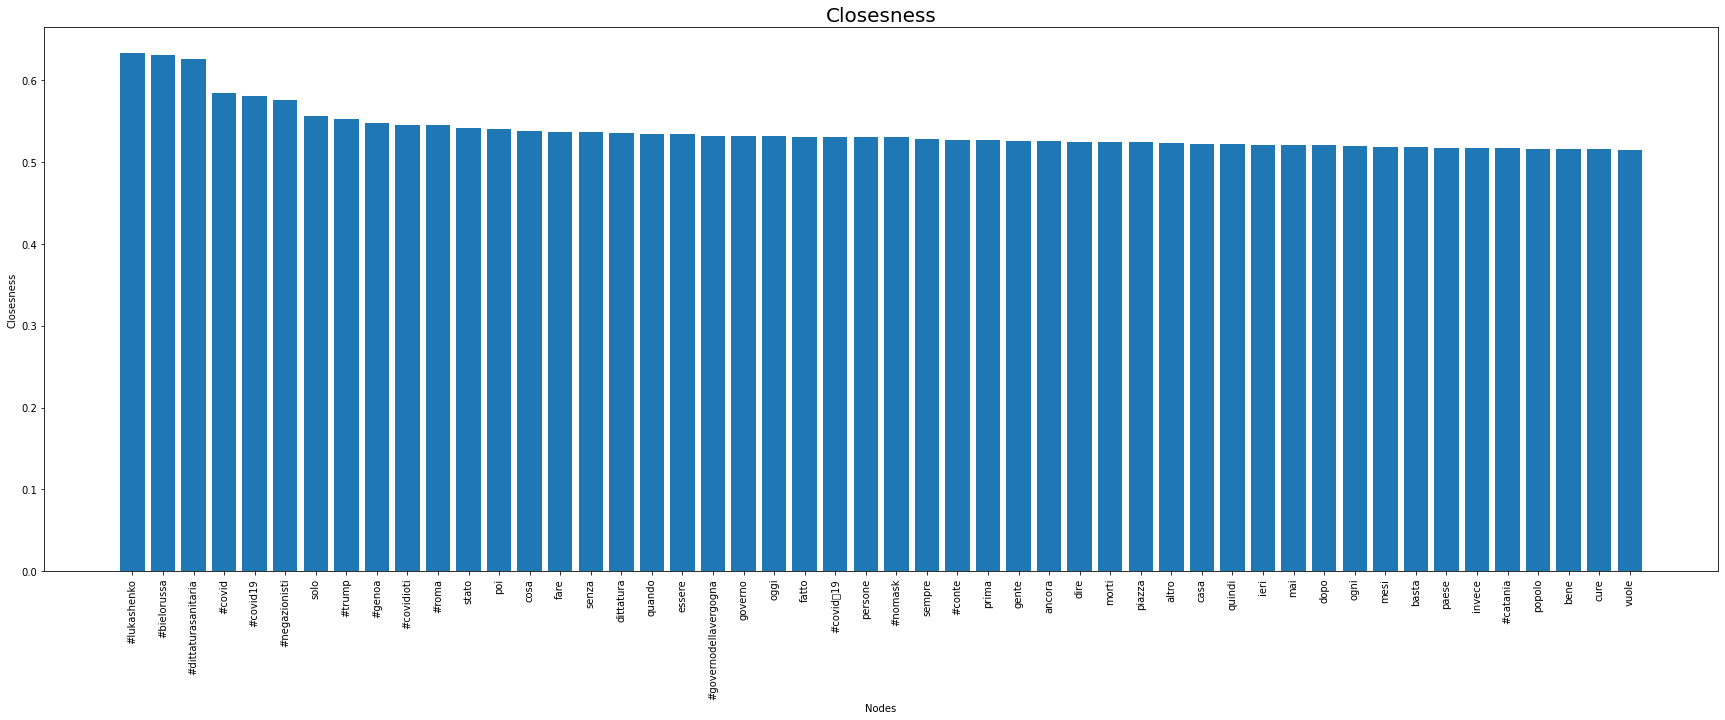

In [ ]:
close = nx.closeness_centrality(G_hybrid_connected)
close_sort = {k : v for k, v in sorted(close.items(), key = lambda t : t[1], reverse = True)}

plt.figure(figsize=(30,10))
plt.bar(list(close_sort.keys())[0:50],height=list(close_sort.values())[0:50])
plt.xticks(rotation=90)
plt.title("Closesness",fontsize=20)
plt.ylabel("Closesness")
plt.xlabel("Nodes")
plt.show()

### Global Clustering coefficient

In [ ]:
print("Global clustering coefficient", iG_hybrid_connected.transitivity_undirected())

Global clustering coefficient 0.11062367167002662


### Local clustering coefficiet 

In [ ]:
# LOCAL CC - ARE THE NEIGHBOURS OF THE NODES ALSO CONNECTED?
import math
print("Local clustering components:")
local_ccs = iG_hybrid_connected.transitivity_local_undirected()
nodes = iG_hybrid_connected.vs()
sum_cc = 0
for local_cc in local_ccs:
    if not math.isnan(local_cc):
        sum_cc += local_cc

for node in nodes:
        
        print("   Local clustering coefficient of node",node.attributes()['_nx_name'],":",local_ccs[node.index])

        
# AVERAGE CC

print("Average clustering component", sum_cc/len(iG_hybrid_connected.vs()))


Output streaming troncato alle ultime 5000 righe.
   Local clustering coefficient of node tracollo : 1.0
   Local clustering coefficient of node ragione : 0.25634725634725636
   Local clustering coefficient of node buon : 0.28297029702970294
   Local clustering coefficient of node altrimenti : 0.23697478991596638
   Local clustering coefficient of node consenso : 0.3368055555555556
   Local clustering coefficient of node incapaci : 0.34918414918414914
   Local clustering coefficient of node zero : 0.27990012484394505
   Local clustering coefficient of node dobbiamo : 0.21709786276715412
   Local clustering coefficient of node unica : 0.161892901618929
   Local clustering coefficient of node cosa : 0.076604917262281
   Local clustering coefficient of node sensata : 0.9166666666666666
   Local clustering coefficient of node amico : 0.2690040954949556
   Local clustering coefficient of node semplice : 0.18046139589328392
   Local clustering coefficient of node tolto : 0.3312020460358056
 

### Assortativity

In [ ]:
print(f"The assortativity of the network: {nx.degree_assortativity_coefficient(G_hybrid_connected)}")

The assortativity of the network: -0.16133433244859013


In [ ]:
deg_dic = dict(G_hashtag_connected.degree) # keys: hashatgs, values: correspondent degree

# make a dictionary with degree:list of hash -> ex. {2:['#something', '#something_else'],...}
deg_times = {}
z = []
for j in deg_dic.values():
  if j not in z:
    l = [k for k, v in deg_dic.items() if v == j]
    deg_times[j] = l
  z.append(j)

In [ ]:
x_degree = []
y_av_neigh = []
for k in deg_times.keys():
  for x in deg_times[k]:
    x_degree.append(k)
    y_av_neigh.append(nx.average_neighbor_degree(G_hashtag_connected)[x])

#-------------------------------------------------------------------------------

x_degree_mean = []
y_av_mean = []
for k in deg_times.keys():
  x_degree_mean.append(k)
  o = []
  for x in deg_times[k]:
    o.append(nx.average_neighbor_degree(G_hashtag_connected)[x])
  y_av_mean.append(np.mean(o))

In [ ]:
# PLOT

fig = plt.figure(figsize = (10, 5))
 
# creating the scatter plot
plt.scatter(np.log(x_degree), np.log(y_av_neigh))
plt.scatter(np.log(x_degree_mean), np.log(y_av_mean),  alpha=0.9)

x = np.log(x_degree_mean)
y = np.log(y_av_mean)

m, b = np.polyfit(x, y, 1)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 'green')
plt.xlabel("log(Degree)")
plt.ylabel("log(k_nn)")

plt.show()

### Comunities detection

In [ ]:
cummunities = {}
for i in np.linspace(1,60,5):
  cummunities[i] = nx_comm.louvain_communities(G_hybrid_connected,resolution=1,seed=int(i))


In [ ]:
salva = True
for i in cummunities:
  print(len(cummunities[i]))
  if salva:
    best_com = cummunities[i]
    salva = False
  for j in cummunities[i]:
      print(j)
  print("\t")

20
{'#seatmusicawards20', 'rotto', 'incorrere', 'fidate', '#ventaglidiparole', '#scienziati', 'materiale', 'rivolto', '#articolouno', 'scaglie', 'insaputa', 'guinzaglio', 'maglia', '#negazionisti', 'studiate', 'notevole', 'circolando', 'diagnosi', '#covid_19', '#qglions', 'spediti', 'rene', 'coltello', 'dormire', 'famiglia', 'frate', '#finedemocrazia', '#lucarelli', 'nemici', 'entrando', 'naturale', '#governodicialtroni', '#economia', '#berlino', 'scoprite', 'sterminio', 'abbraccia', 'esiste', 'pregherete', 'denaro', 'aerei', 'potremmo', 'febbraio', 'appoggiate', 'bello', 'parti', 'veramente', 'giacche', 'recidivo', '#6settembre', 'definisca', 'scovati', '#rosannabenzi', 'baciare', 'esista', 'dipende', 'vivete', '#covidiots', 'tecniche', 'manuale', 'finiva', 'errate', 'correte', 'decennio', 'confuso', 'sfila', 'incoerenti', 'distinguere', 'navi', 'serviva', 'tarda', 'sesso', '#salvinimeloni', 'circolare', 'rappresentano', 'cane', 'scrivevano', 'falla', 'uscita', '#buongiornoatutti', 'c

In [ ]:
for i in cummunities:
      print("Modularity:")
      print(nx_comm.modularity(G_hybrid_connected,cummunities[i]))
      print("\t")


Modularity:
0.4443254906023966
	
Modularity:
0.44259979771483454
	
Modularity:
0.4426285221013744
	
Modularity:
0.44498690156471044
	
Modularity:
0.4446914968051852
	


### Make the pagerank on the single comunities and analyze the tweets

In [ ]:
best_com = cummunities[60]
comunity_network = {}
counter = 1
for i in best_com:
  comm = list(i)
  up_weighted_hashtag_prevax = []
  for i in range(edge_words.shape[0]):
    if (edge_words.iloc[i,0] in comm) and (edge_words.iloc[i,1] in comm):
      up_weighted_hashtag_prevax.append((edge_words.iloc[i,0],edge_words.iloc[i,1],edge_words.iloc[i,2]))
  G_com = nx.Graph()
  G_com.add_weighted_edges_from(up_weighted_hashtag_prevax)
  pr = nx.pagerank(G_com)
  pr = list({k : v for k, v in sorted(pr.items(), key = lambda t : t[1], reverse = True)}.keys())[:9]
  comunity_network[counter] = pr
  counter +=1

In [ ]:
pd.Series(comunity_network).to_csv("/content/drive/MyDrive/Network_Science_covid_project/An_com/words_prevaxcamp.csv")

In [ ]:
counter = 1
list_of_text_com = []
for i in comunity_network.values():
    for index, row in tweets_filtered.iterrows():
      if type(row["hashtags"]) is list:
        for j in row["hashtags"]:
          if j in i:
            list_of_text_com.append({"comunità":counter,"text":row["text"]})
      if type(row["hashtags"]) is str:
        if row["hashtags"]==j:
          list_of_text_com.append({"comunità":counter,"text":row["text"]})
      for l in i:
        if l in row["clean_text"]:
          list_of_text_com.append({"comunità":counter,"text":row["text"]})
    counter+=1

In [ ]:
test_comunity_text = pd.DataFrame(list_of_text_com,index=[i for i in range(len(list_of_text_com))])

In [ ]:
test_comunity_text.drop_duplicates(inplace=True)

In [ ]:
test_comunity_text.shape

(9560, 2)

In [ ]:
test_comunity_text.to_csv("/content/drive/MyDrive/Network_Science_covid_project/An_com/text_prevaxcamp_words.csv")

### Robustness (if we are able)

In [ ]:
import random

def robustness(g):

    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_giantcomponentnodes = []
    luppolo=0

    for x in range(g.number_of_nodes()):
        best_node = nx.nodes(g_remove_most_important)
        best_node2 = []
        for n in best_node:
            best_node2.append(n)

        best_node = random.choice(best_node2)

        if x % 5 == 0:
          luppolo +=1
          comps = list(nx.connected_components(g_remove_most_important))
          
          giant_comp = max(comps, key=len)
          comp_nodes_number = len(giant_comp)
          comp_len = len(comps)

          list_giantcomponentnodes.append(comp_nodes_number)
          list_components.append(comp_len)
          list_removed.append(x)

        g_remove_most_important.remove_nodes_from([best_node])
    return list_removed, list_giantcomponentnodes




def attack(g):

    most_imp = pd.Series(dict(g.degree)).sort_values(ascending=False)
    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_giantcomponentnodes = []
    for x in range(g.number_of_nodes()):
        best_node = nx.nodes(g_remove_most_important)
        best_node2 = []
        for n in best_node:
            best_node2.append(n)

        best_node = most_imp.index[x]
        comps = list(nx.connected_components(g_remove_most_important))
        giant_comp = max(comps, key=len)
        comp_nodes_number = len(giant_comp)
        comp_len = len(comps)

        list_giantcomponentnodes.append(comp_nodes_number)
        list_components.append(comp_len)
        list_removed.append(x)
        g_remove_most_important.remove_nodes_from([best_node])
    return list_removed, list_giantcomponentnodes

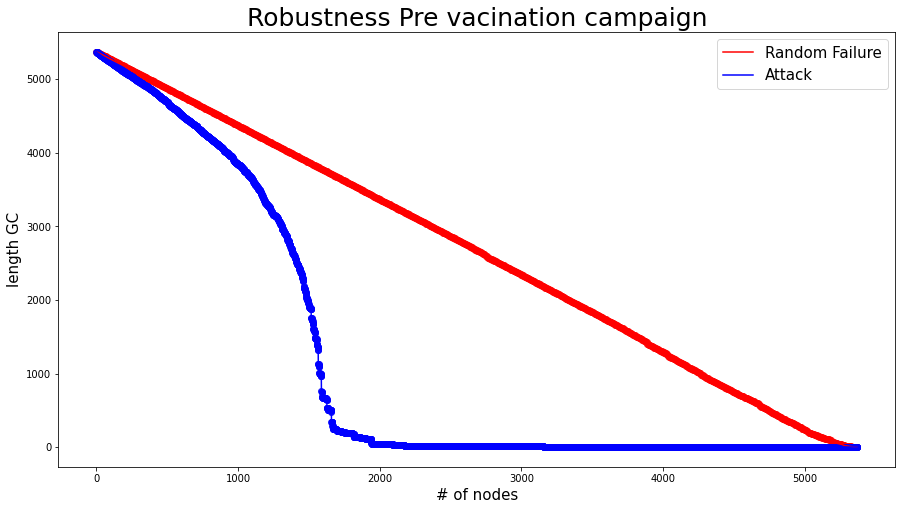

In [ ]:
x_rob, y_rob = robustness(G_hybrid_connected)
x_att, y_att = attack(G_hybrid_connected)

fig = plt.figure(figsize=(15,8))
ran = plt.scatter(x=x_rob, y=y_rob, 
                 color='red', alpha=0.8)
plt.plot(x_rob, y_rob, color='red', label='Random Failure')
  
att = plt.scatter(x=x_att, y=y_att, 
                 color='blue', alpha=0.8)
plt.plot(x_att, y_att, color='blue', label='Attack')
plt.title('Robustness Pre vacination campaign', fontsize=25)
plt.xlabel("# of nodes", fontsize=15)
plt.ylabel("length GC", fontsize=15)
plt.legend(prop={'size': 15})